\title{Time Series Analysis on Alphabet Stock}
\author{Alexander Sanchez \\ \texttt{a\_sanchez200@ucsb.edu}}
\date{}

\begin{document}
\maketitle

\begin{abstract}
This study investigates the impact of significant economic events on Alphabet Inc. (GOOG) stock prices, focusing on the COVID-19 pandemic. We employed rolling statistics, log transformation, first-order differencing, and seasonal differencing with a lag of six to stabilize variance and remove non-linear trends in the time series data. The Augmented Dickey-Fuller (ADF) test confirmed the stationarity of the transformed data. 

For the modeling, we utilized SARIMA and SARIMAX models. The SARIMAX model included exogenous variables such as the US inflation rate, the US federal funds effective rate, the CBOE Volatility Index (VIX), and the NASDAQ-100 Technology Sector index. These variables were standardized to improve the model's numerical stability. Our SARIMAX model demonstrated a good fit with an AIC of -525.98. Diagnostic tests indicated no significant autocorrelation and normal distribution of residuals, although heteroskedasticity was present. 

The results showed that both the 2008 financial crisis and the COVID-19 pandemic had significant non-linear impacts on Alphabet's stock prices. The federal fund's effective rate and the VIX played crucial roles in influencing the stock prices, reflecting market risk aversion and economic uncertainty. Including these exogenous variables in the SARIMAX model provided a comprehensive understanding of the factors affecting Alphabet's stock prices.

Overall, the study highlights the importance of considering macroeconomic indicators and market volatility in time series forecasting models to effectively capture the underlying trends and patterns in stock prices.
\end{abstract}

## Abstract

This study investigates the impact of significant economic events on Alphabet Inc. (GOOG) stock prices, focusing on the COVID-19 pandemic. We employed rolling statistics, log transformation, first-order differencing, and seasonal differencing with a lag of six to stabilize variance and remove non-linear trends in the time series data. The Augmented Dickey-Fuller (ADF) test confirmed the stationarity of the transformed data. For the modeling, we utilized SARIMA and SARIMAX models. The SARIMAX model included exogenous variables such as the US inflation rate, the US federal funds effective rate, the CBOE Volatility Index (VIX), and the NASDAQ-100 Technology Sector index. These variables were standardized to improve the model's numerical stability.

Our SARIMAX model demonstrated a good fit with an AIC of -525.98. Diagnostic tests indicated no significant autocorrelation and normal distribution of residuals, although heteroskedasticity was present. The results showed that both the 2008 financial crisis and the COVID-19 pandemic had significant non-linear impacts on Alphabet's stock prices. The federal fund's effective rate and the VIX played crucial roles in influencing the stock prices, reflecting market risk aversion and economic uncertainty. Including these exogenous variables in the SARIMAX model provided a comprehensive understanding of the factors affecting Alphabet's stock prices.

Overall, the study highlights the importance of considering macroeconomic indicators and market volatility in time series forecasting models to effectively capture the underlying trends and patterns in stock prices.

In [1]:
import numpy as np
import pandas as pd

import statsmodels.tsa.stattools as ts
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from itertools import product

from time_series_utils_updated import adf_test, plot_rolling_statistics, optimize_SARIMA
from time_series_utils_updated import plot_sarima_train_predictions
from time_series_utils_updated import plot_sarima_test_predictions_conf_in, optimize_SARIMAX 
from time_series_utils_updated import plot_sarimax_train_predictions 
from time_series_utils_updated import plot_sarimax_test_predictions_conf_in
from time_series_utils_updated import plot_sarima_predictions, plot_sarimax_predictions

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib import rcParams
from cycler import cycler

rcParams['figure.figsize'] = 18, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
#rcParams['axes.prop_cycle'] = cycler(color=['#365977'])
rcParams['lines.linewidth'] = 2.5

# Alphabet Inc. Stock

In [2]:
import yfinance as yf
import seaborn as sns

RISKY_ASSET = "GOOG"
START_DATE = "2006-01-01"
END_DATE = '2024-06-01' # "2024-05-01"

alphabet_stock = yf.download(RISKY_ASSET,
                 start=START_DATE,
                 end=END_DATE,
                 interval='1mo')
                 # adjusted=True)

print(f"Downloaded {alphabet_stock.shape[0]} rows of data.")

[*********************100%%**********************]  1 of 1 completed

Downloaded 221 rows of data.


In [3]:
alphabet_stock.rename(columns={'Adj Close':'Adjusted_Close'}, inplace=True)

# Create a DataFrame for 'Close' prices
close_df = alphabet_stock[['Close']]

# Create a DataFrame for 'Adjusted_Close' prices
adjusted_close_df = alphabet_stock[['Adjusted_Close']]

print(adjusted_close_df.head())
print(adjusted_close_df.tail())

            Adjusted_Close
Date                      
2006-01-01       10.749708
2006-02-01        9.009521
2006-03-01        9.689795
2006-04-01       10.383982
2006-05-01        9.238101
            Adjusted_Close
Date                      
2024-01-01      141.452621
2024-02-01      139.437561
2024-03-01      151.886993
2024-04-01      164.236664
2024-05-01      173.533829


In [4]:
TRAIN_END_DATE = "2022-12-01"
TEST_START_DATE = "2023-01-01"

# Split the data into training and testing sets
train_data = alphabet_stock.loc[:TRAIN_END_DATE, 'Adjusted_Close']
test_data = alphabet_stock.loc[TEST_START_DATE:, 'Adjusted_Close']

print(train_data.head())
print(train_data.tail())

Date
2006-01-01    10.749708
2006-02-01     9.009521
2006-03-01     9.689795
2006-04-01    10.383982
2006-05-01     9.238101
Name: Adjusted_Close, dtype: float64
Date
2022-08-01    108.882599
2022-09-01     95.914452
2022-10-01     94.428101
2022-11-01    101.201469
2022-12-01     88.512634
Name: Adjusted_Close, dtype: float64


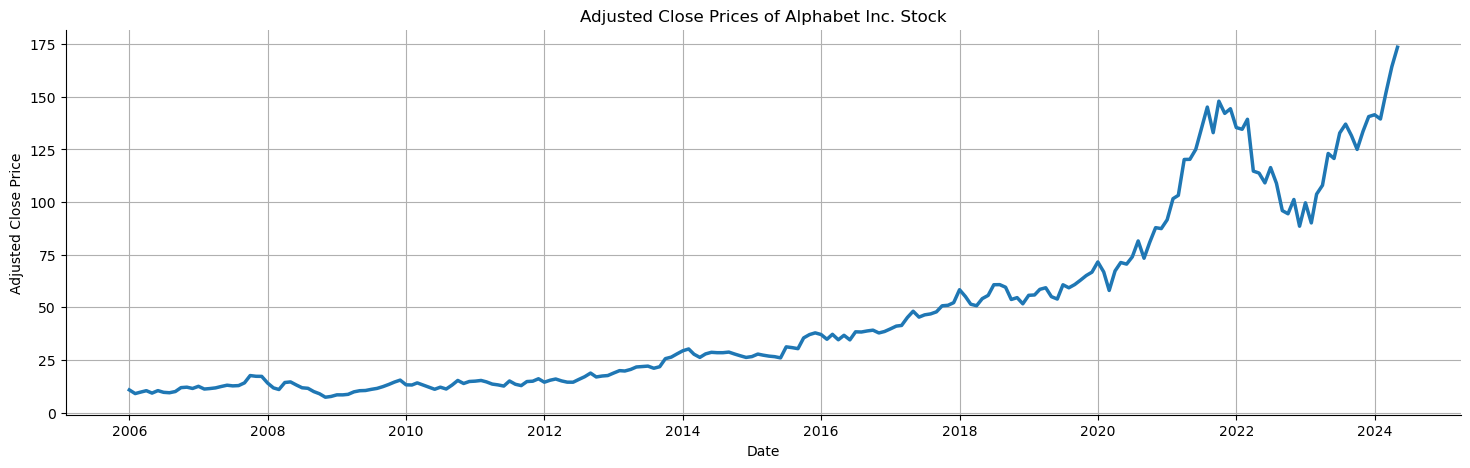

In [5]:
# Adding labels and title
plt.plot(adjusted_close_df)
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Adjusted Close Prices of Alphabet Inc. Stock')
plt.grid(True)

plt.show()

In [6]:
print(adjusted_close_df.head())
print(adjusted_close_df.tail())

            Adjusted_Close
Date                      
2006-01-01       10.749708
2006-02-01        9.009521
2006-03-01        9.689795
2006-04-01       10.383982
2006-05-01        9.238101
            Adjusted_Close
Date                      
2024-01-01      141.452621
2024-02-01      139.437561
2024-03-01      151.886993
2024-04-01      164.236664
2024-05-01      173.533829


# Introduction

This project aims to examine how the COVID-19 pandemic impacted Alphabet Inc.'s stock performance after the pandemic. Specifically, it explores whether time series analysis could have predicted the optimistic recovery of the stock or if it would have anticipated a significant decline, often referred to as a 'falling knife.' By comparing this to the 2008 financial crisis, we observe similar patterns but under different economic responses. After the 2008 crisis, the Federal Reserve engaged in quantitative easing, and Congress bailed out major banks. From 2010 to 2016, the federal funds rate remained near zero, and interest rates were low. This changed after 2016, with increasing rates leading to predictions of a recession by 2019, even before the pandemic struck. When COVID-19 hit, the federal funds rate dropped to zero overnight, and quantitative easing was reintroduced. Despite the subsequent increase in the federal funds rate from 2022, Alphabet's stock plummeted but rose to new highs.

The purpose of studying this dataset is to analyze Alphabet Inc.'s stock performance after the pandemic to determine if time series analysis, specifically SARIMA and SARIMAX models, could have predicted the significant rise in stock price despite the challenging circumstances. This analysis is crucial for understanding the stock's behavior during a global crisis and whether its historic rise was predictable, contrasting the different economic environments of the COVID-19 pandemic and the 2008 financial crisis.

# Data

The dataset spans from January 1, 2006, to May 1, 2024, with a monthly frequency comprising 221 observations. It contains the adjusted closing prices of Alphabet Inc. stock, measured in US dollars. Yahoo Finance collected this data. Adjusted closing prices are crucial for reflecting the stock's value and accounting for corporate actions like dividends and stock splits. I chose this dataset to analyze how Alphabet's stock performed during and after the COVID-19 pandemic. Understanding this behavior provides insights into market reactions during global crises and helps evaluate the predictive power of time series analysis in forecasting stock trends.


# Methodology
## Exploratory Data Analysis

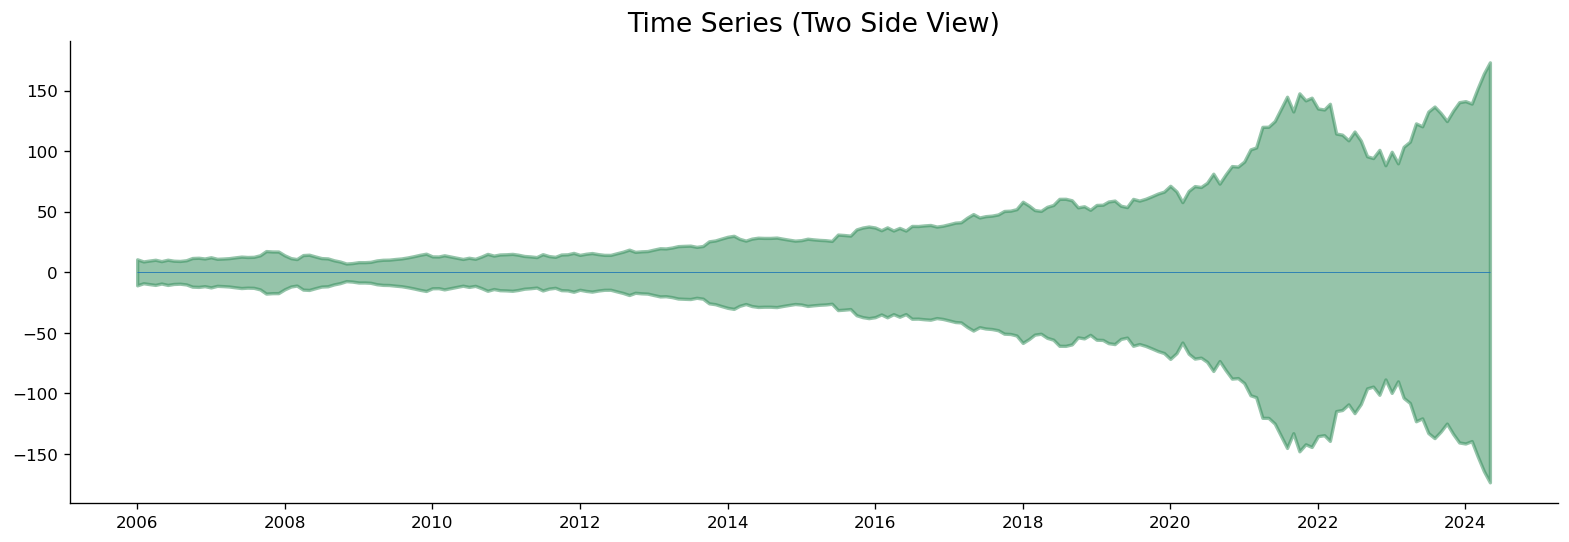

In [7]:
# Draw plot
x = adjusted_close_df['Adjusted_Close'].index
y1 = adjusted_close_df['Adjusted_Close'].values

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.title('Time Series (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(x), xmax=np.max(x), linewidth=.5)
plt.show()

The stock price of Alphabet in 2006, which was called Google, was at \$10.78 a stock. Now, in 2024, Alphabet stock is priced at \\$164.64. We will examine a time series two side view to see the growth of Alphabet stock. As we can see, there has been a dramatic growth. From 2014 onward, its stock price has been dramatically growing, then in 2020, during COVID-19, the stock price skyrocketed, reaching historic levels. However, around 2022, its stock price started to decline. In 2023, its stock price rose again, ultimately surpassing historic highs.

There are a couple of inferences we can make from our plot. The time series' mean is most likely not constant; thus, a trend exists. Considering the stock price increases significantly from 2020 to 2022, the standard deviation is not constant. Thus, our time series is most likely non-stationary. Even so, we still must properly check for seasonality and trend. We will make seasonal plots, year-wise box plots (to examine trend), and month-wise box plots (to examine seasonality) and graph the rolling statistic of our time series, visually seeing if the mean and standard deviation are not constant.

## Checking for Trend and Seasonality

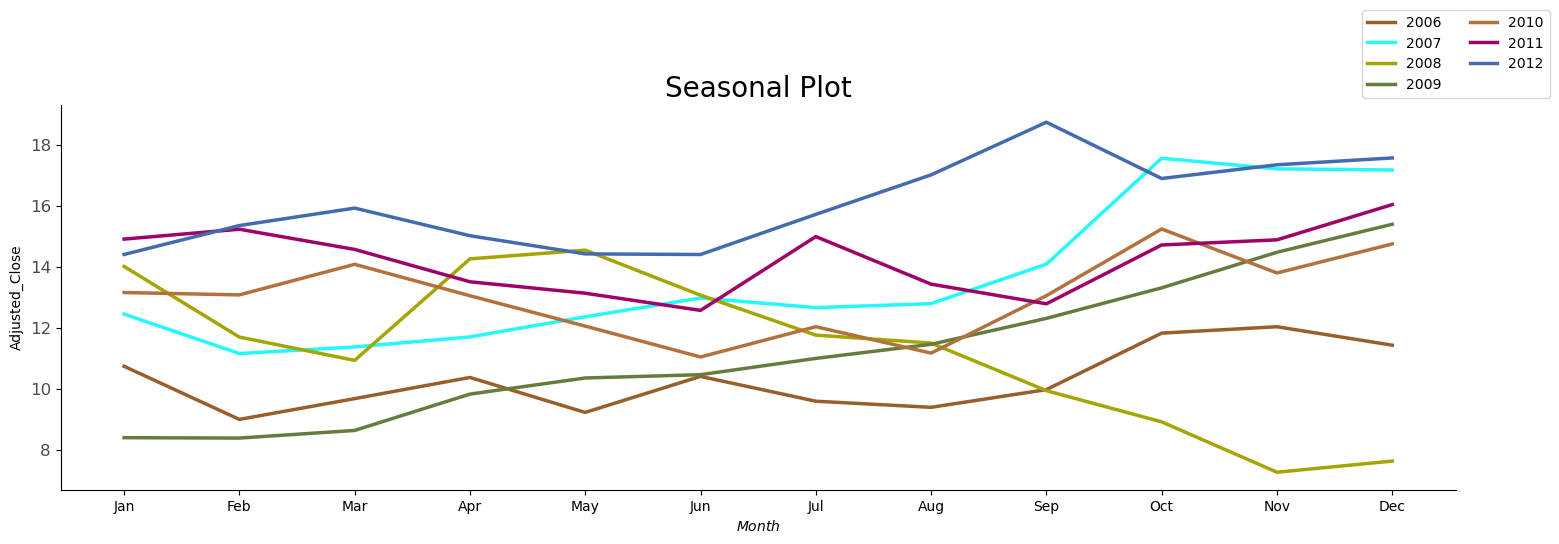

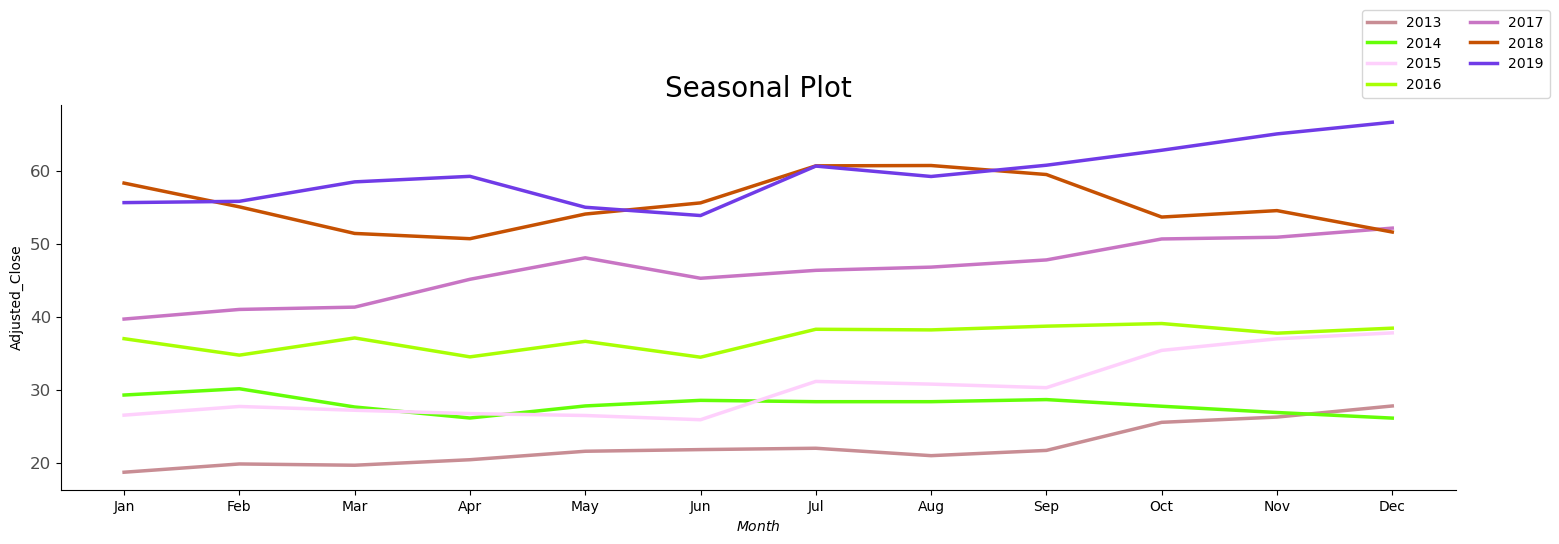

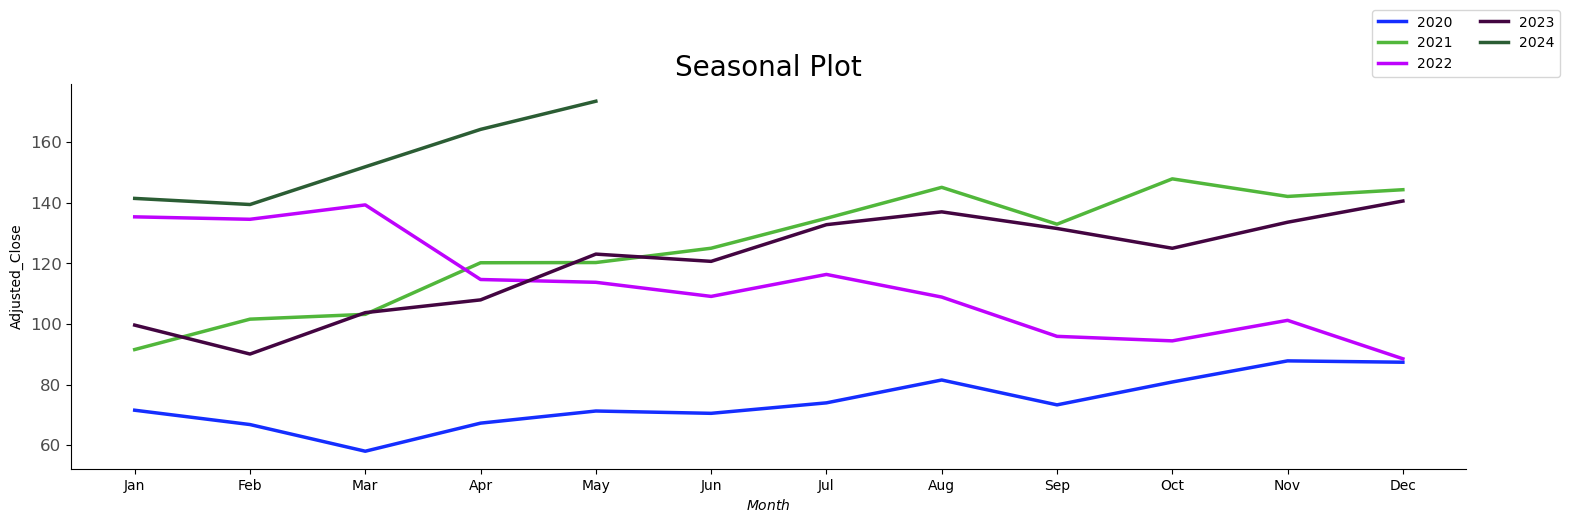

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Prepare data
adjusted_close_df['year'] = adjusted_close_df.index.year
adjusted_close_df['month'] = adjusted_close_df.index.strftime('%b')
years = adjusted_close_df['year'].unique()

# Prep Colors
np.random.seed(12)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plots
for i, y in enumerate(years):
    if i % 7 == 0:
        if i > 0:
            plt.gca().set(ylabel='Adjusted_Close', xlabel='$Month$')
            plt.yticks(fontsize=12, alpha=.7)
            plt.legend(loc='lower center', bbox_to_anchor=(1.0, 1.0), ncol=2)
            plt.title("Seasonal Plot", fontsize=20)
            plt.show()
        #plt.figure(figsize=(16, 8), dpi=80)
    plt.plot('month', 'Adjusted_Close', data=adjusted_close_df.loc[adjusted_close_df.year == y, :], color=mycolors[i], label=y)

# Show last plot
plt.gca().set(ylabel='Adjusted_Close', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.legend(loc='lower center', bbox_to_anchor=(1.0, 1.0), ncol=2)
plt.title("Seasonal Plot", fontsize=20)
plt.show()

We examine our time series to see if it has seasonality or a trend. We will graph yearly seasonal plots by a seven-year interval, except for 2020 to 2024. We will also examine a year-wise box plot and a monthly-wise box plot.

Our seasonal plot reveals a dynamic trend in stock prices. The average stock price from 2006-2012 hovers around \$13.00, showing a relatively stable period. However, the average stock price from 2013 to 2019 jumps to around \\$40.00, indicating a significant increase. The average stock price from 2020 to 2024 further escalates to around \\$100.00, highlighting the market's volatility and the non-constant nature of the mean. 

We will create a box plot of the whole time series from 2006 to 2024.

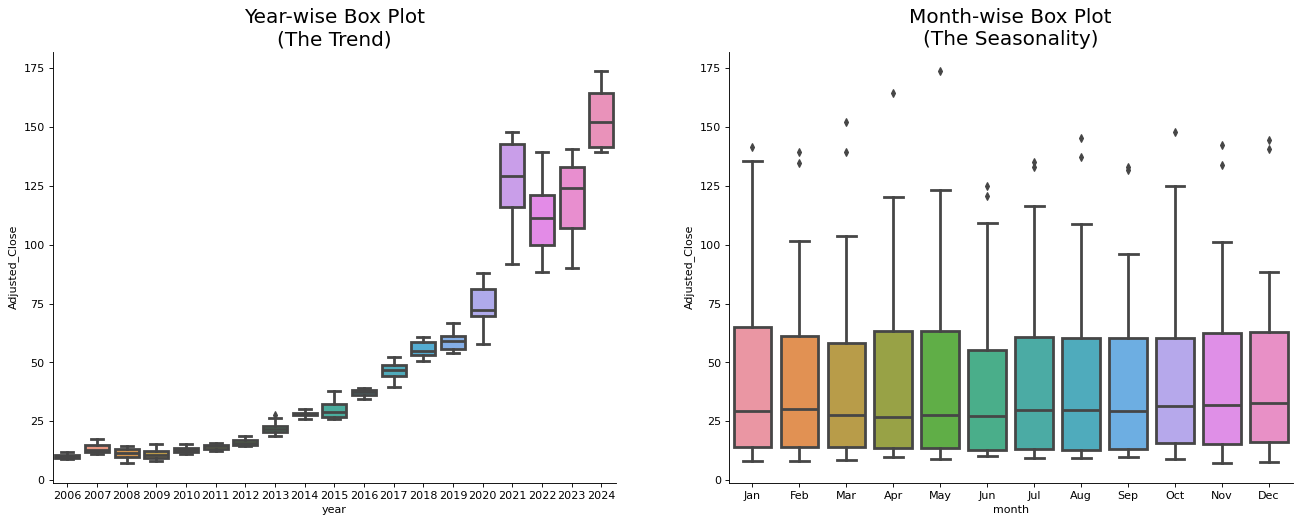

In [9]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='Adjusted_Close', data=adjusted_close_df, ax=axes[0])
sns.boxplot(x='month', y='Adjusted_Close', data=adjusted_close_df, ax=axes[1])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

Looking at our year-wise box plot, we see the stock price rising over the years. From 2006 to 2016, 50% of the stock price (the box) spread was small, and its whiskers were close. From 2017 onward, the whiskers spread farther apart, indicating more significant variability in extreme values. The month-wise box plot shows that the median stock price is the same for all months. While the lower whisker is closer to our box for all months, the upper whisker is farther away. Since the upper whisker is longer, the data is positively skewed (right-skewed). Thus, most stocks are concentrated on the lower end, with a few higher stocks stretching out the upper whisker.

We will now break our time series apart. We will examine the year-wise and month-wise box plots from 2006 to 2018 and 2018 to 2024.

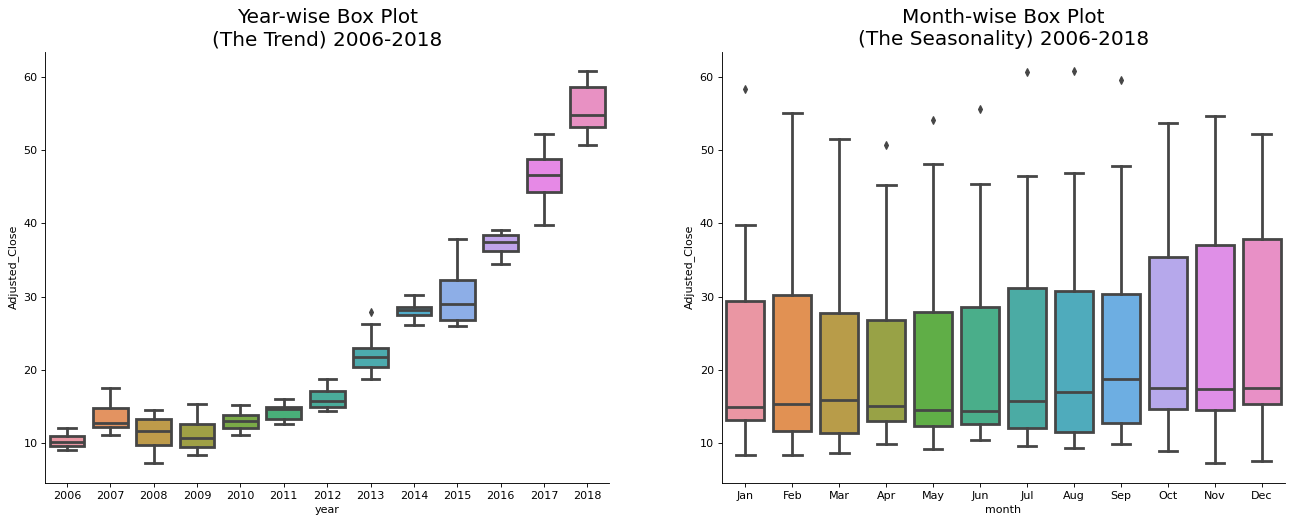

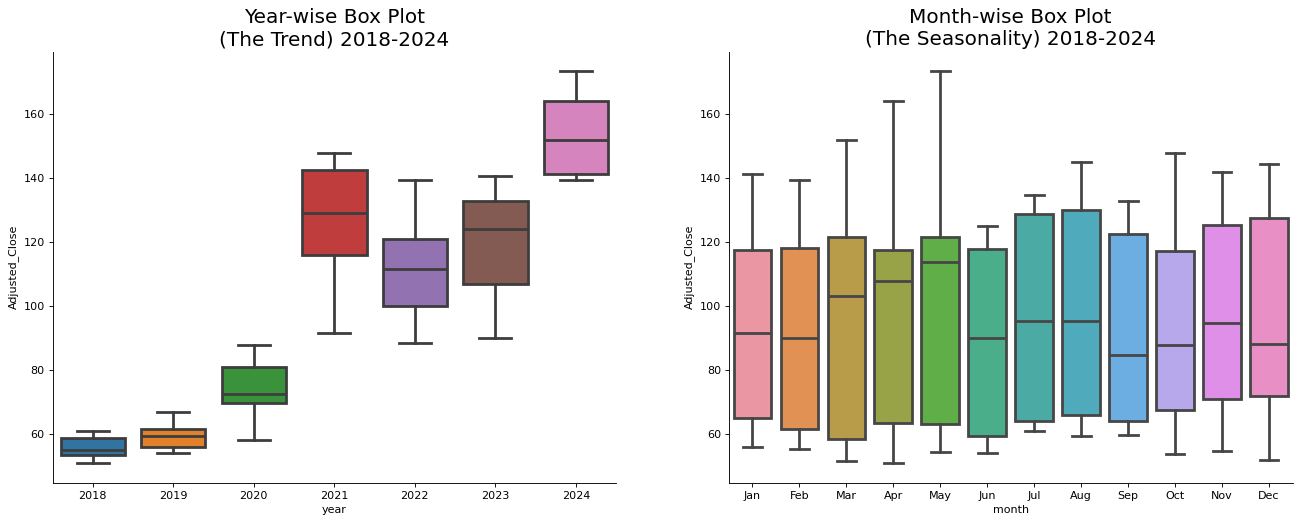

In [10]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='Adjusted_Close', data=adjusted_close_df.loc[adjusted_close_df.index.year <= 2018, :], ax=axes[0])
sns.boxplot(x='month', y='Adjusted_Close', data=adjusted_close_df.loc[adjusted_close_df.index.year <= 2018, :], ax=axes[1])
# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend) 2006-2018', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality) 2006-2018', fontsize=18)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='Adjusted_Close', data=adjusted_close_df.loc[adjusted_close_df.index.year >= 2018, :], ax=axes[0])
sns.boxplot(x='month', y='Adjusted_Close', data=adjusted_close_df.loc[adjusted_close_df.index.year >= 2018, :], ax=axes[1])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend) 2018-2024', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality) 2018-2024', fontsize=18)
plt.show()

Our 2006 to 2018 year-wise box plot shows that the average stock prices and variability rise. The month-wise box plot shows that the median is relatively the same throughout the year. Note that the median is on the lower end of the box plot throughout the year. We can see that 50% of the stock price is not constant. The box grows smaller, making our stock prices more concentrated and less unstable. However, later on, as the box plot grows. Thus, the stock price of that month became more unstable. This suggests that the stock is less volatile in certain months, and in others, it is more volatile.


Our 2018 to 2024 year-wise box plot shows that the average stock prices and variability rise. From 2020 to 2021, the stock price dramatically rose, though the 2021 box plot's lower whisker suggests the stock price was negatively skewed for that year. We see the same thing for the stock price in 2023. Now, you may ask: Why does this matter? Considering that 2021 was when the mass vaccination program began, and people were returning to work, and 2023 was when interest rates and the federal fund's effective rate rose and were assumed to remain high, many became pessimistic about Alphabet stock.

In [11]:
adjusted_close_df.drop(columns = ['year', 'month'], inplace=True)

## Time Series Rolling Statistic


We will now perform a rolling statistic on our time series data. We will calculate a half-year rolling mean(moving average) and rolling standard deviation. The rolling mean helps smooth out variation and provides a clearer trend in the data. The rolling standard deviation measures the variability of the data within the window.


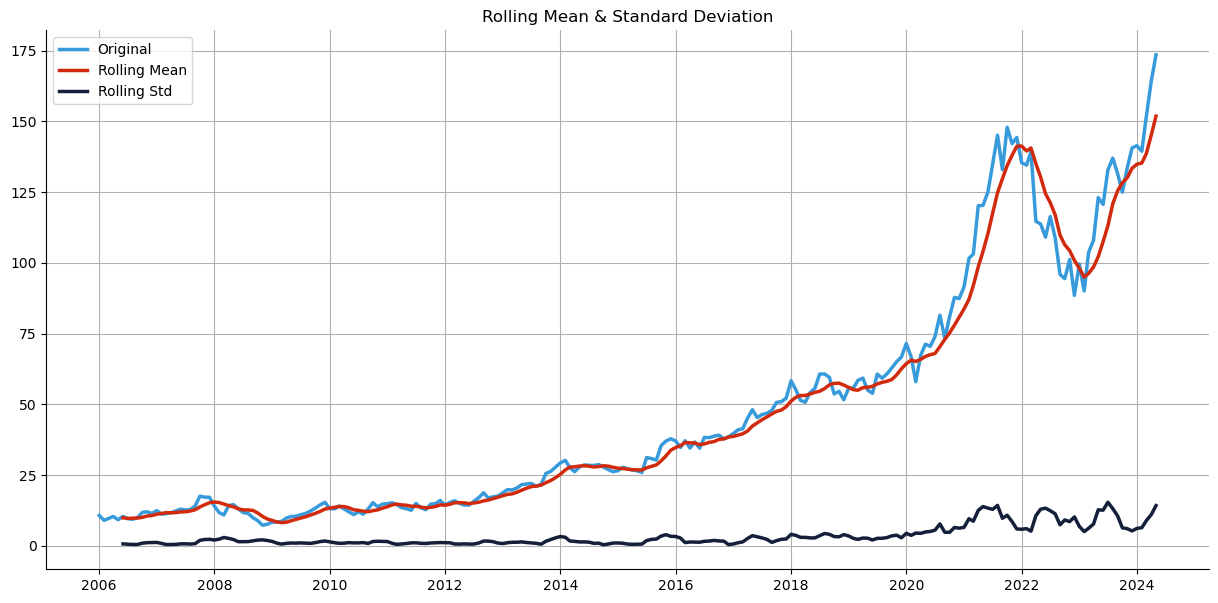

In [12]:
plot_rolling_statistics(adjusted_close_df, 'Adjusted_Close', 6)

From our rolling statistic, we can see the mean over time. The standard deviation initially stayed relatively flat until 2018. From then on, the standard deviation increased and became quite unstable from 2021 to 2024. It is safe to assume the mean is non-linear, apparent from 2020 to 2024. The variance is not constant since the standard deviation increases around 2018 and becomes unstable from 2020 onward. Thus, we will log transform our time series data to stabilize the variance and make our non-linear, exponential-like trend (mean) into a linear trend or reduce the non-linear behavior.

In [13]:
log_Adjusted_Close = np.log(adjusted_close_df[['Adjusted_Close']])
log_Adjusted_Close.rename(columns= {'Adjusted_Close': 'log_Adjusted_Close' },inplace=True)

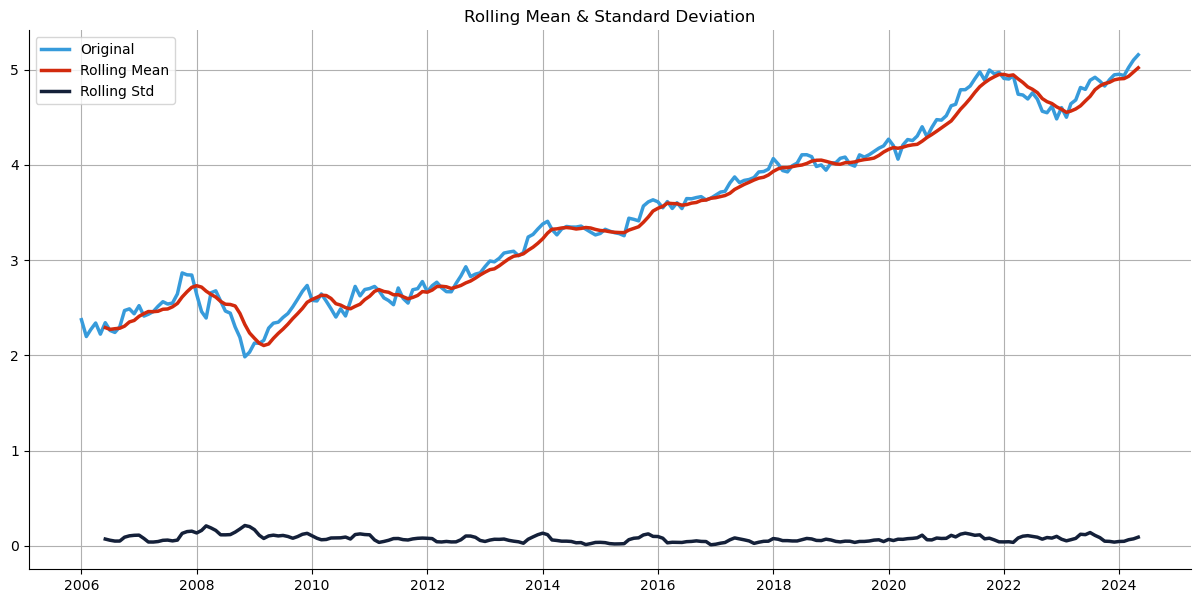

In [14]:
plot_rolling_statistics(log_Adjusted_Close, 'log_Adjusted_Close', 6)

As we can see, our log transform stabilized the variance. The standard deviation is near zero, resembling white noise. The log transforms have reduced the trend's non-linear behavior. We can see the similarities between the financial crisis of 2008 and the recession due to COVID-19. They both went up, then down, then up again. From 2009 to 2020, the exponential-like trend was reduced.

Nonetheless, our mean nowhere near resembles white noise. Even though our mean is linear at certain intervals, and at two intervals, the trend is non-linear, we will differentiate our times series to reduce the trend. Considering there are non-linear trends at two intervals, we will consider SARIMA and SARIMAX models. Since the difference will not completely eliminate the non-linear trend, we will consider adding a constant in our SARIMA and SARIMAX models.

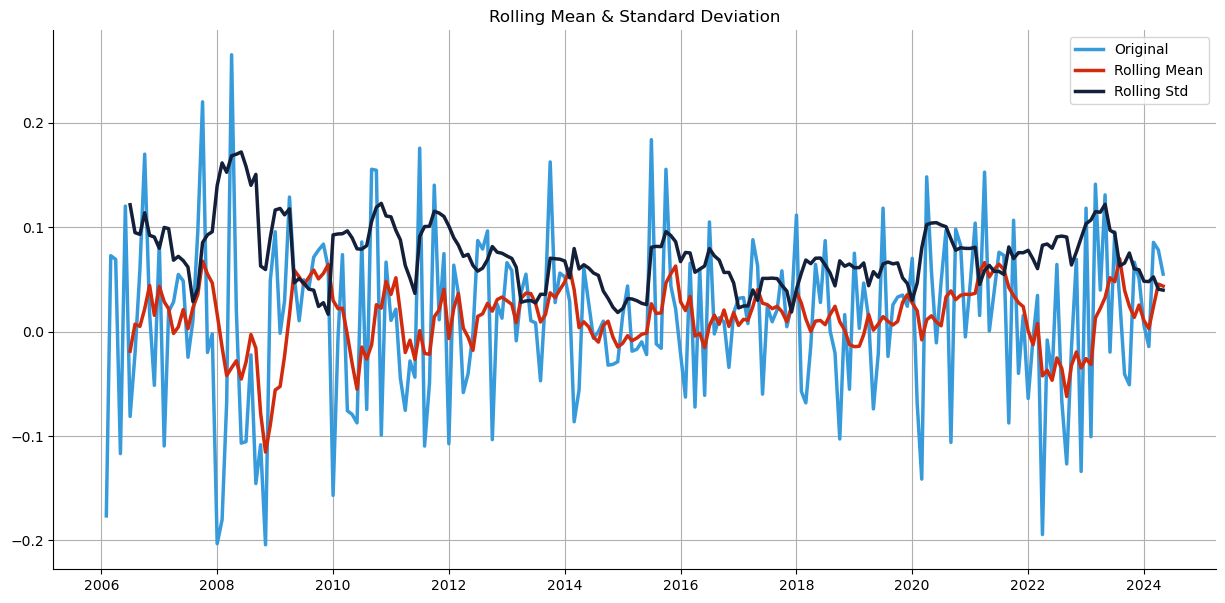

In [15]:
plot_rolling_statistics(log_Adjusted_Close.diff(), 'log_Adjusted_Close', 6)

The difference removed the linear trend in our time series data. Now, our time series data resembles white noise. Examining our means more closely, we can still see that the non-linear trend in the 2008 financial crisis and the COVID-19 recession still exists. For our SARIMA and SARIMAX models, we can set the trend. The options are 'n' (no trend), 'c' (constant or intercept), 't' (a linear trend with time), and 'ct' (constant and linear trend). Considering there is a trend in our original time series data, option 'n' is removed. Since the trend is non-linear, 't' and 'ct' will also be removed. This leaves us with setting the trend to 'c.' Setting our trend to 'c' means adding a constant to our SARIMA and SARIMAX models. Adding this constant component captures the average level of the time series, helping stabilize the mean. Since our original data has variability, the constant component will help capture the average level. After transforming and multiple differencing techniques, adding a linear or more complex technique seems unnecessary. Thus, when fitting our SARIMA `trend = 'c'`. This will not be the case for our SARIMAX model. Since we will add four exogenous variables to our SARIMAX model to capture the trends and underlying patterns in Alphabet stock prices, it is reasonable to exclude the constant term. Thus, there will be no trend component for our SARIMAX model.

## ADF Test, ACF & PACF Plots

### Log Transform and First-Order Differencing

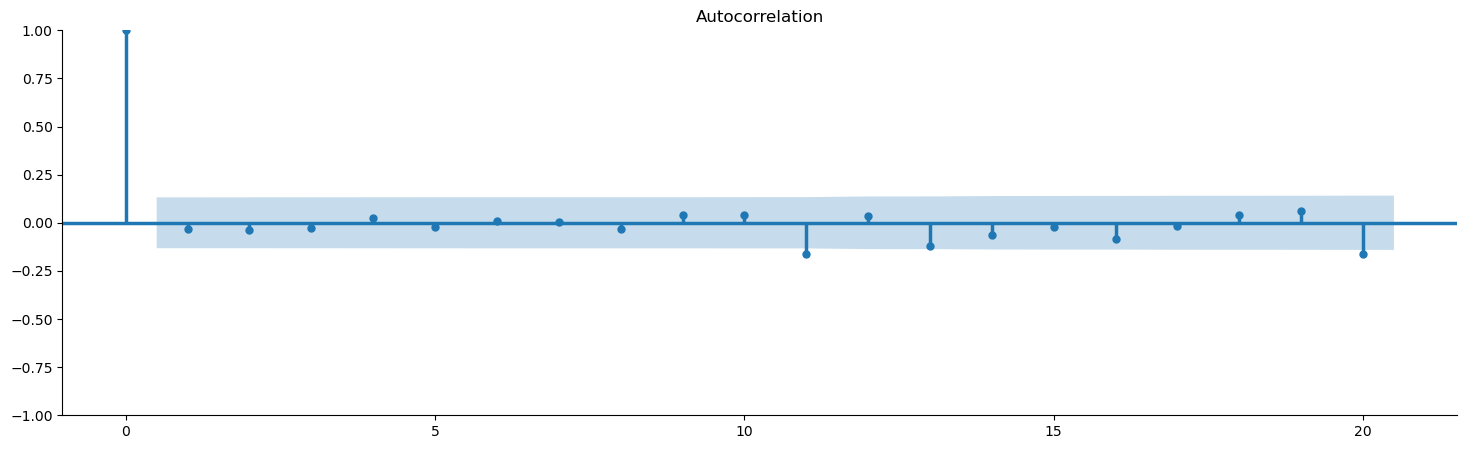

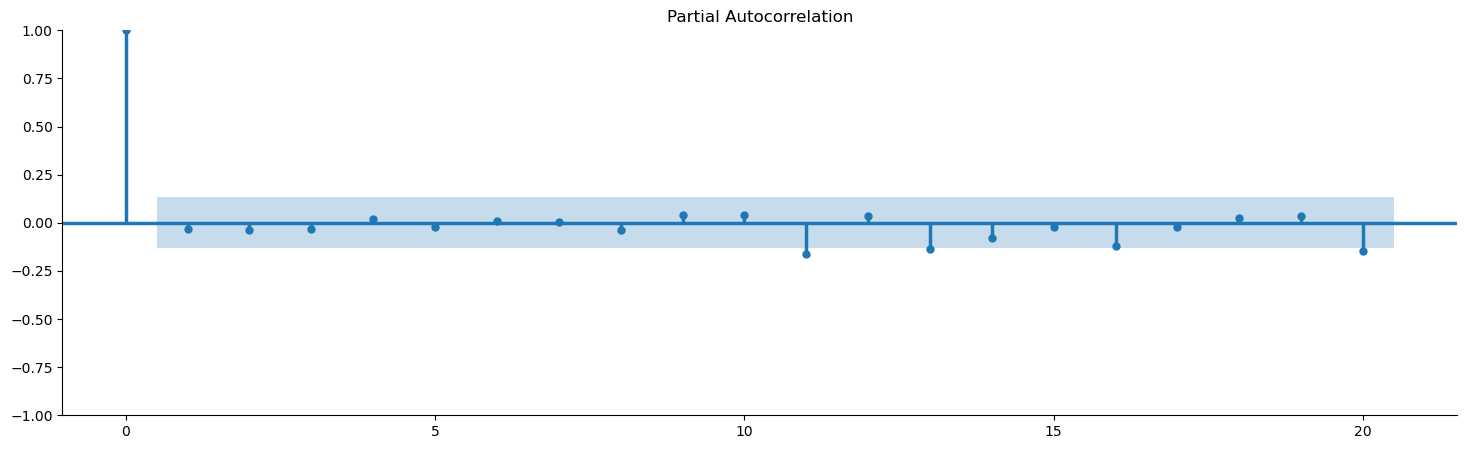

In [16]:
diff_log_adj = log_Adjusted_Close.diff().dropna()
plot_acf(diff_log_adj['log_Adjusted_Close'], lags=20);
plot_pacf(diff_log_adj['log_Adjusted_Close'], lags=20);

After transforming the data logarithmically and performing first-order differencing, I generated autocorrelation function (ACF) and partial autocorrelation function (PACF) plots. Our analysis of the ACF and PACF revealed no notable correlation at any lag. While some correlations are observed at lag ten and beyond, they are relatively weak. Consequently, for our SARIMA and SARIMAX models, we will opt for a range of 0 to 2 for both the non-seasonal p and q parameters.

### Log Transform, First-Order Differencing, and Seasonal Differencing with s = 6


In [17]:
season_diff_log_adj = diff_log_adj.diff(6).dropna()
adf_test(season_diff_log_adj['log_Adjusted_Close'])

ADF Test Result:
ADF Statistic: -6.652905661271454
p-value: 5.067992756071334e-09
Critical Values:
   1%: -3.4631437906252636
   5%: -2.8759570379821047
   10%: -2.574454682874228


We log-transformed the data, performed first-order differencing, and applied seasonal differencing with a lag of six. We will perform an ADF test on our modified data. Our ADF statistic -6.63 is much lower than the critical values at all significance levels (1%: -3.46, 5%: -2.88, and 10%: -2.57), and our p-value 5.71e-09 is much smaller than 0.05. Based on our ADF test, we reject the null hypothesis and do not reject that the time series is stationary.

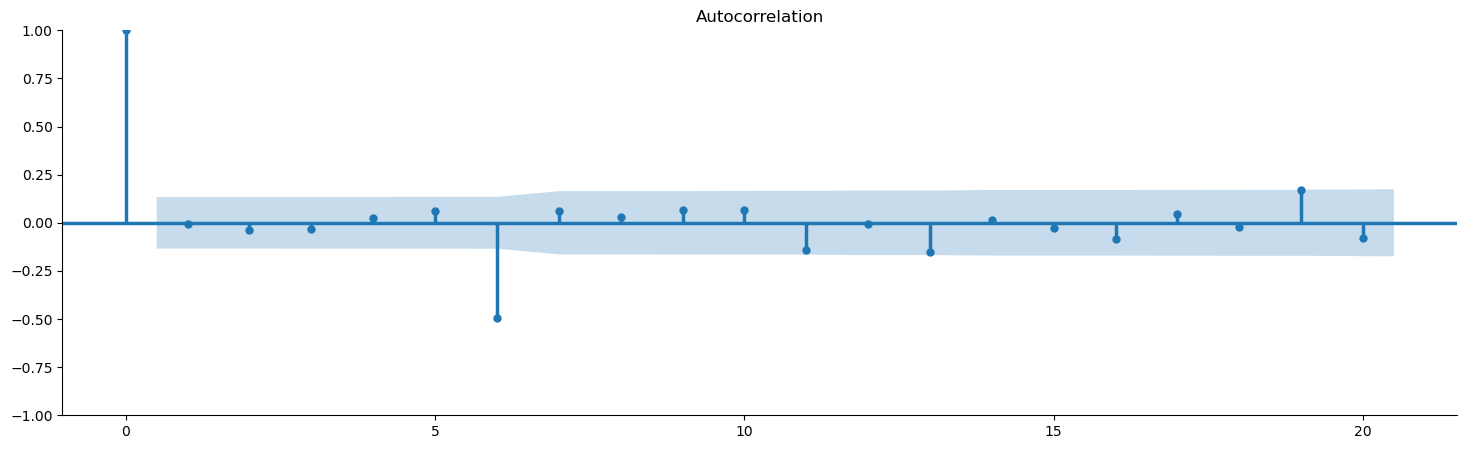

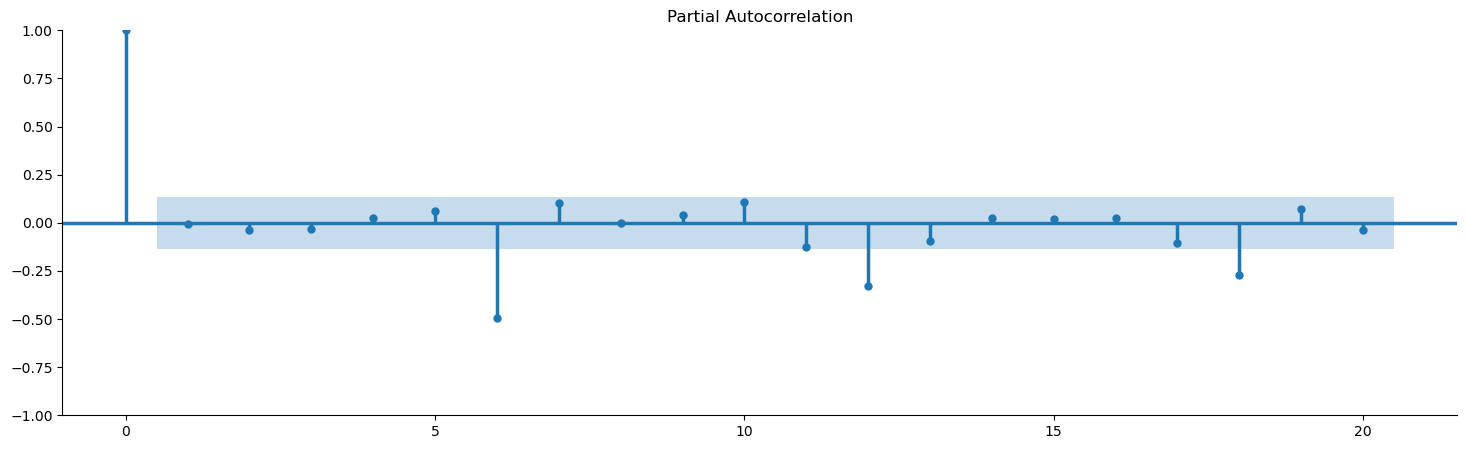

In [18]:
plot_acf(season_diff_log_adj['log_Adjusted_Close'], lags=20);
plot_pacf(season_diff_log_adj['log_Adjusted_Close'], lags=20);

After transforming the data logarithmically and performing first-order differencing and seasonal differencing using a six-period lag, I generated autocorrelation function (ACF) and partial autocorrelation function (PACF) plots. Both plots exhibited autocorrelation at a lag of six, indicating a presence of seasonality. Although most lags fell within the confidence interval, lags 1, 2, and 3 were below it, implying negative autocorrelation, while lag 4 showed positive autocorrelation.

The interpretation is nuanced regarding lags 1, 2, and 3 being within the confidence interval but negatively correlated, followed by lag 4 showing a positive correlation but not being statistically significant. Considering this complexity, setting the seasonal p and q parameters depends on the desired model's sensitivity to capturing short-term fluctuations versus longer-term seasonal patterns. One approach is to initially consider setting seasonal p and q to 3 or 4 to account for potential seasonal effects up to lag 4. Alternatively, exploring a wider range, such as setting ranges for both seasonal p and q from 0 to 3 or 4, allows for a comprehensive search of the optimal parameters using model selection techniques and validation data assessment. Thus we will settle for the latter.

## Train - Test Window Split


In [19]:
TRAIN_END_DATE = "2022-12-01"
TEST_START_DATE = "2023-01-01"

# Split the data into training and testing sets
train_data = log_Adjusted_Close.loc[:TRAIN_END_DATE, 'log_Adjusted_Close']
test_data = log_Adjusted_Close.loc[TEST_START_DATE:, 'log_Adjusted_Close']

print(train_data.head())
print(train_data.tail())

Date
2006-01-01    2.374879
2006-02-01    2.198282
2006-03-01    2.271073
2006-04-01    2.340264
2006-05-01    2.223336
Name: log_Adjusted_Close, dtype: float64
Date
2022-08-01    4.690270
2022-09-01    4.563457
2022-10-01    4.547839
2022-11-01    4.617113
2022-12-01    4.483145
Name: log_Adjusted_Close, dtype: float64


# Results

## SARIMA$(p,d,q)(P,D,Q)_m$ Model

## SARIMA$(p,d,q)(P,D,Q)_m$ Model

The general equation for SARIMA can be expressed as:

$$
y_t = \sum_{i=1}^{p} \phi_i y_{t-i} + \sum_{j=1}^{q} \theta_j \epsilon_{t-j} + \sum_{k=1}^{P} \Phi_k y_{t-km} + \sum_{l=1}^{Q} \Theta_l \epsilon_{t-lm} + \epsilon_t
$$

Where:
- $ y_t $ is the observed value at time $ t $.
- $ \phi_i $ are the non-seasonal autoregressive coefficients.
- $ \theta_j $ are the non-seasonal moving average coefficients.
- $ \Phi_k $ are the seasonal autoregressive coefficients.
- $ \Theta_l $ are the seasonal moving average coefficients.
- $ \epsilon_t $ is the error term at time $ t $.
- $ m $ is the seasonal period.


A SARIMA$(p,d,q)(P,D,Q)_m$ model is characterized by six terms $(p, d, q, P, D, Q)$ and a seasonal period $m$:

### Non-Seasonal Components:
* $p$ is the order of the autoregressive (AR) model.
* $d$ stands for differencing (I) and indicates the number of times we difference the time series data to make it stationary.
* $q$ stands for the order of the moving average (MA) window.

### Seasonal Components:
* $P$ is the seasonal autoregressive (SAR) order.
* $D$ is the seasonal differencing order.
* $Q$ is the seasonal moving average (SMA) order.
* $m$ is the seasonal period.

The full SARIMA equation incorporating seasonal components is given by:

$$
\Phi_p(B) \Phi_P(B^m) (1 - B)^d (1 - B^m)^D y_t = \Theta_q(B) \Theta_Q(B^m) \epsilon_t
$$

Where:
- $\Phi_p(B)$ is the non-seasonal autoregressive polynomial of order $p$.
- $\Phi_P(B^m)$ is the seasonal autoregressive polynomial of order $P$.
- $(1 - B)^d$ represents non-seasonal differencing of order $d$.
- $(1 - B^m)^D$ represents seasonal differencing of order $D$.
- $\Theta_q(B)$ is the non-seasonal moving average polynomial of order $q$.
- $\Theta_Q(B^m)$ is the seasonal moving average polynomial of order $Q$.
- $B$ is the backshift operator such that $B y_t = y_{t-1}$.

### Summary:
- Non-seasonal part: $ (p, d, q) $
- Seasonal part: $ (P, D, Q) $
- Seasonal period: $ m $

Thus, we'll do the following:
* `ps = range(0, 3)`: Defines the range of values for the AR parameter $p$ from 0 to 2.
* `ds = 1`: Sets the difference $d$ to 1.
* `qs = range(0, 3)`: Sets the range for the MA parameter $q$ from 0 to 2.

For the seasonal part of the SARIMA model, we'll define:
* `Ps = range(0, 5)`: Defines the range of values for the seasonal AR parameter $P$ from 0 to 4.
* `Qs = range(0, 5)`: Sets the range for the seasonal MA parameter $Q$ from 0 to 4.
* `D = 0`: Seasonal differencing parameter, we'll set $D$ to 0.
* `s = 6`: Seasonal period, we'll set $s$ to 6 (monthly data).

We will be computing 225 SARIMA models. This will take some time, around 5 minutes.


Before we review the results, we should review how the selection process was determined.

For SARIMA and SARIMAX models, the structure is defined by two main parts: the non-seasonal part $(p, d, q)$ and the seasonal part $(P, D, Q)$, with the seasonal period denoted by $m$. We will select a range from 0-2 for our non-seasonal AR and MA parameters. We will select a range from 0-4 for our seasonal AR and MA parameters. For our non-seasonal difference, we will set it to 0. We will set our seasonal difference to zero. For our seasonal period, we will set it to six. 

I have a function that automates the process of selecting the optimal SARIMA. This function systematically evaluates a range of SARIMA models with different parameter combinations and identifies the optimal model based on the AIC. It automates the model selection process, which can be time-consuming if done manually. The result is a data frame sorted by AIC, where the first row corresponds to the best model according to the AIC criterion. There is another function for the case of SARIMAX that does the same thing.

For my SARIMAX model, I included four exogenous variables. Those four exogenous variables are the US inflation rate, the US federal funds effective rate, the CBOE Volatility Index (the fear index), and the NASDAQ-100 Technology Sector. We are using the US inflation rate since high inflation can erode consumer purchasing power, reducing discretionary spending, meaning people are less likely to spend on products. Since consumers are less willing to spend, advertisers will decrease spending on ads, thus affecting Alphabet's profit. For the federal fund's effective rate, changes in the federal funds affect borrowing costs for businesses and consumers. Higher rates, or increasing rates, incentivize banks to be more risk-averse, leading to a reduction in spending and investments. Lower or decreasing rates incentivize banks to be less risk-averse, leading to an increase in spending and investments. The spending component affects whether companies/advertisers increase or decrease advertising on Alphabet. In contrast, the investment component will increase or decrease capital flow into Alphabet stock. This can inflate the stock and then plummet, so knowing when to sell becomes crucial. The CBOE Volatility Index (VIX) measures market expectations of near-term volatility conveyed by S&P 500 stock index option prices. Thus, higher VIX means higher market uncertainty and risk aversion. This led to more cautious investment strategies, reducing capital flow into the stock market. This will make companies more conservative in their spending, reducing Alphabet's ad revenue. Since it will also reduce capital flow into the stock market, this could also inflate Alphabet stock and fall considerably later. The NASDAQ-100 Technology Sector index tracks the performance of technology companies within the NASDAQ-100 index, reflecting the overall health and performance of the tech sector. Considering Alphabet is a major tech company, the NASDAQ Technology Sector will measure the overall trend of the tech sector. Before fitting our model, we will standardize the exogenous variables since they vary widely in magnitude. This will also stabilize the variance and improve the numerical stability of the model fitting process.

For SARIMA and SARIMAX models, the structure is defined by two main parts: the non-seasonal part $(p, d, q)$ and the seasonal part $(P, D, Q)$, with the seasonal period denoted by $m$.

To specify the non-seasonal part, we set up the following parameters:

* ps = range(0, 3): AR parameter $p$ ranges from 0 to 2.
* ds = 1: Difference parameter $d$ is set to 1.
* qs = range(0, 3): MA parameter $q$ ranges from 0 to 2.

For the seasonal part, we define:

* Ps = range(0, 5): Seasonal AR parameter $P$ ranges from 0 to 4.
* Qs = range(0, 5): Seasonal MA parameter $Q$ ranges from 0 to 4.
* D = 0: Seasonal differencing parameter $D$ is set to 0.
* s = 6: Seasonal period $s$ is set to 6 (monthly data).

This setup results in computing a total of 225 SARIMA models, which may take approximately 3 minutes to complete.

In [20]:
ps = range(0, 3)
qs = range(0, 3)
Ps = range(0, 5)
Qs = range(0, 5)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 0
m = 6

In [21]:
SARIMA_result_df = optimize_SARIMA(train_data, SARIMA_order_list, d, D, m)

  0%|          | 0/225 [00:00<?, ?it/s]

In [22]:
SARIMA_result_df.head(10)

,"(p,q,P,Q)",AIC
0,"(0, 0, 1, 3)",-450.937619
1,"(0, 0, 0, 0)",-450.224893
2,"(0, 0, 1, 1)",-450.130663
3,"(0, 0, 1, 2)",-449.897132
4,"(0, 0, 1, 4)",-449.579496
5,"(0, 0, 4, 1)",-449.559830
6,"(0, 0, 3, 1)",-449.485559
7,"(0, 0, 2, 1)",-449.480251
8,"(1, 0, 1, 3)",-448.593780
9,"(0, 1, 0, 0)",-448.253353


## Fitting SARIMA


In [23]:
# Extract the parameters from row 0 of result_df
params_sarima = SARIMA_result_df.iloc[0]['(p,q,P,Q)']
p, q, P, Q = params_sarima

## SARIMA$(p,d,q)(P,D,Q)_m$ Model

In [24]:
SARIMA_model = SARIMAX(train_data, 
                       order=(p,d,q), 
                       seasonal_order=(P,D,Q,m), 
                       simple_differencing=False,
                       trend='c')
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                         SARIMAX Results                                         
Dep. Variable:                        log_Adjusted_Close   No. Observations:                  204
Model:             SARIMAX(0, 1, 0)x(1, 0, [1, 2, 3], 6)   Log Likelihood                 231.469
Date:                                   Thu, 17 Oct 2024   AIC                           -450.938
Time:                                           17:28:01   BIC                           -431.058
Sample:                                       01-01-2006   HQIC                          -442.895
                                            - 12-01-2022                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.001      0.705      0.481    

Our AIC is -450.94, indicating a good model fit. I will focus most on the diagnostic section. The Ljung-Box test checks for autocorrelation in our model. The Jarque-Bera test checks whether the residuals follow a normal distribution. The Heteroskedasticity checks for the presence of heteroskedasticity, meaning it checks if the variance is non-constant. The Skew measures the asymmetry of the residuals around the mean. Kurtosis measures the tailedness of the residual's distribution. 

Based on our results, the Ljung-Box test suggests no significant autocorrelation. The Jarque-Bera test suggests the residuals are normally distributed. However, our Heteroskedasticity indicates that the variance is non-constant, meaning the variance changes over time. Our Skew suggests asymmetry in the residuals, which is more likely a negative skew. Our kurtosis suggests close to normal kurtosis.

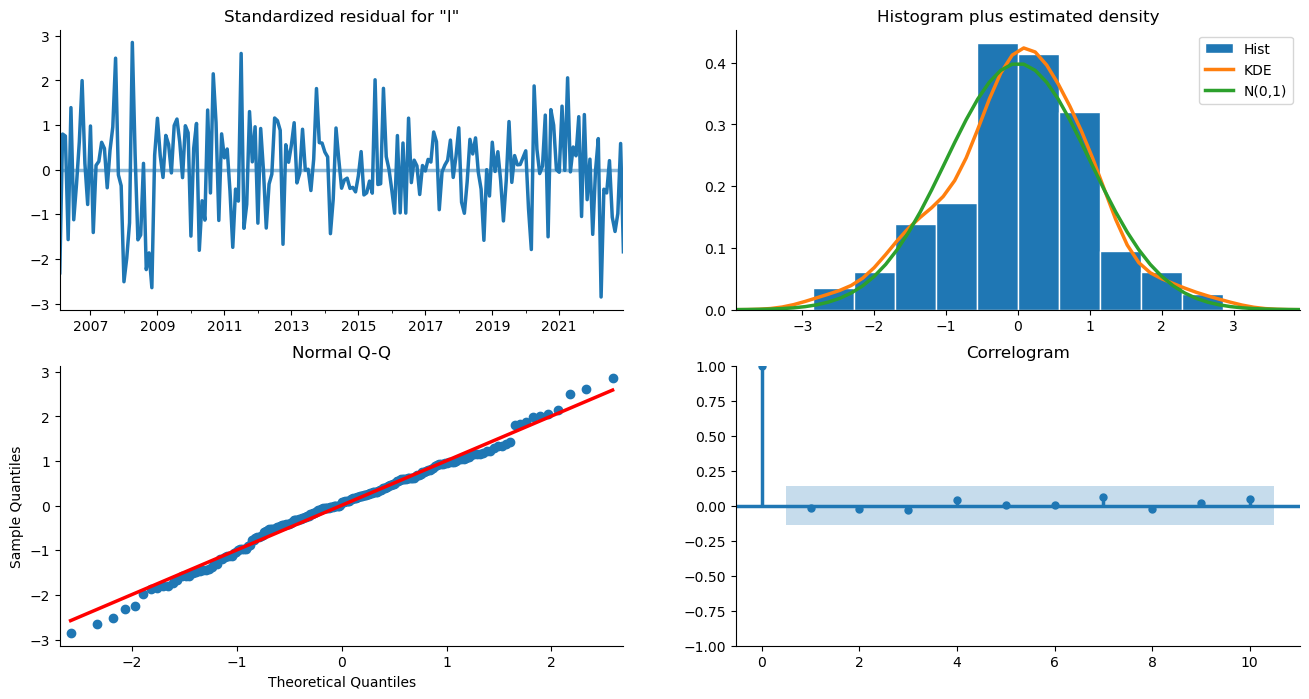

In [25]:
SARIMA_model_fit.plot_diagnostics(figsize=(16, 8));

Our histogram appears to be close to normal, though there is a slight skew to the right. Examining our QQ plot, the residuals deviate from the line, particularly around the tails. The QQ plot suggests the residuals may not be perfectly normal. The correlogram suggests no autocorrelation in the residuals. The standardized residuals suggest the model's errors are i.i.d.

## SARIMA Train/Test Predictions


In [26]:
pred_start_date = train_data.index[0]
pred_end_date = train_data.index[-1]

sarima_predictions = SARIMA_model_fit.predict(start=pred_start_date, end=pred_end_date)
sarima_residuals = train_data - sarima_predictions

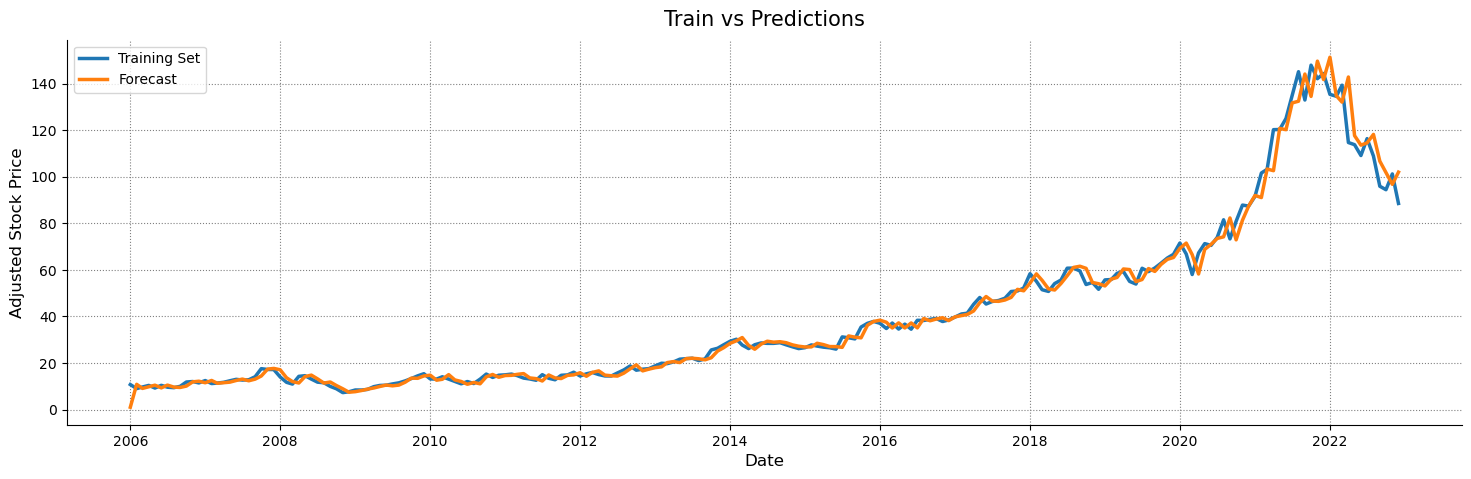

In [27]:
plot_sarima_train_predictions(train_data, sarima_predictions)

In [28]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

sarima_predictions = SARIMA_model_fit.predict(start=pred_start_date, end=pred_end_date)
sarima_residuals_test = np.exp(test_data - sarima_predictions)

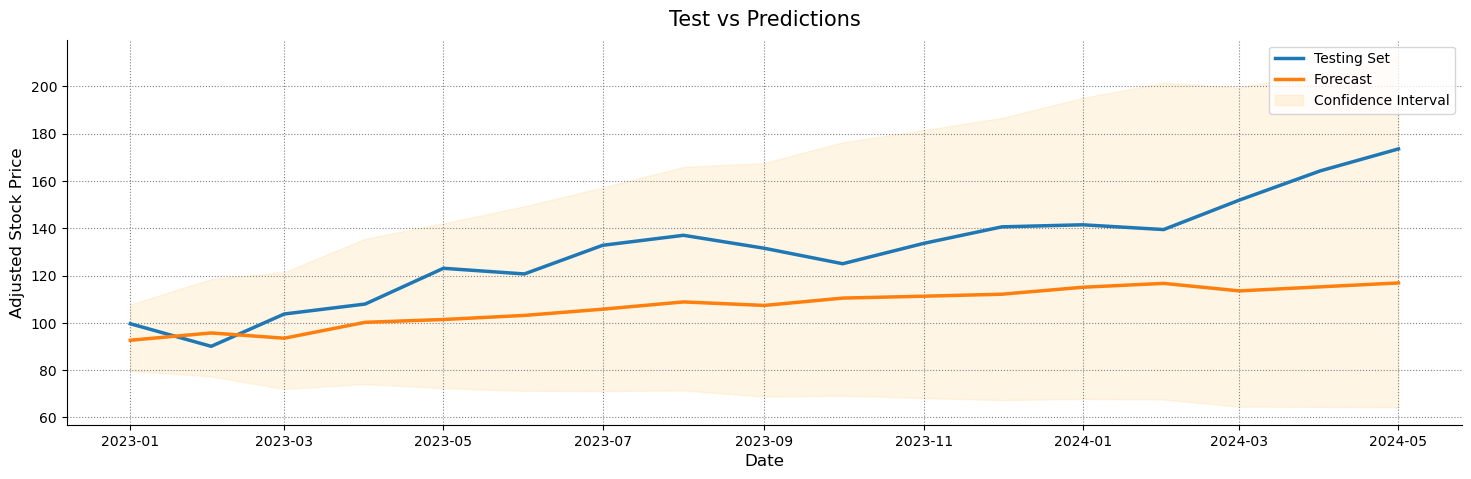

In [29]:
sarima_conf_in = SARIMA_model_fit.get_prediction(start=pred_start_date, end=pred_end_date).conf_int()
plot_sarima_test_predictions_conf_in(test_data, sarima_predictions, sarima_conf_in)

Examining our test set against our forecast, we see that the forecast tracks the overall trend of the actual stock price. It is also apparent that the forecast does not encapsulate the erratic behavior of the stock price. We see from the confidence interval that the interval starts small but gradually gets bigger when forecasting further out in time. The upper interval increases significantly relative to the lower interval. According to the confidence interval, there is a higher probability of the price being higher than to be lower. Based on the model's uncertainty, expect higher prices than lower prices. However, the widening confidence interval reflects the increasing uncertainty and risk that comes with it.

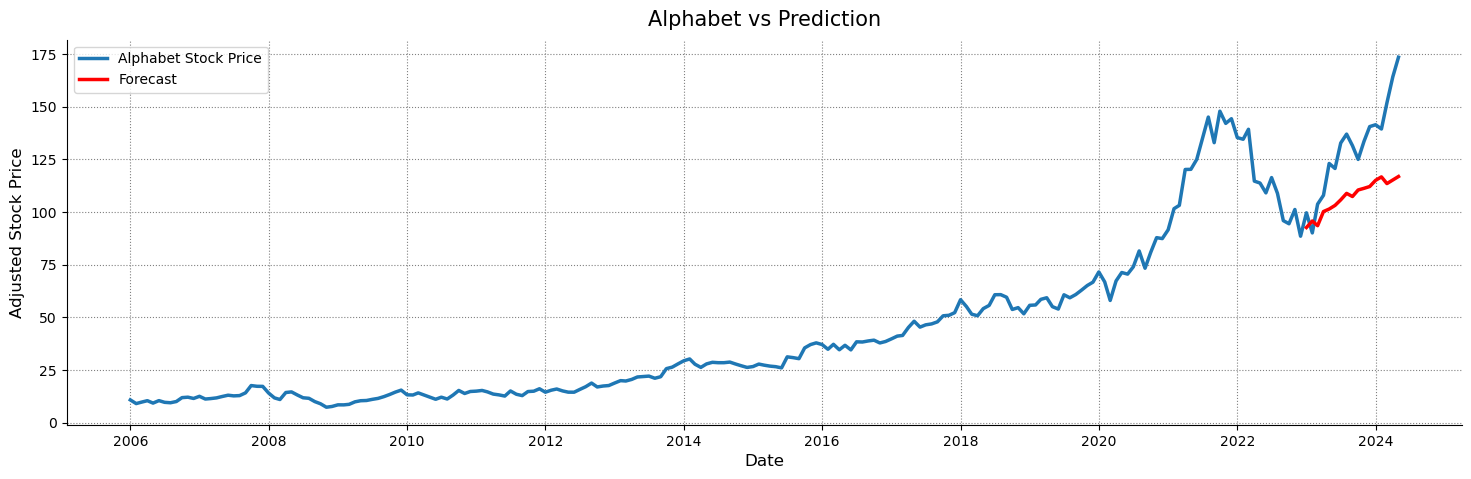

In [30]:
plot_sarima_predictions(adjusted_close_df, sarima_predictions)

## SARIMA Evaluations

## Train Set Error

In [31]:
# Assuming residuals are in log scale
sarima_residuals = SARIMA_model_fit.resid

# Back-transform residuals to the original scale
original_scale_residuals = np.exp(sarima_residuals)   # Assuming log transformation was log(value)

# Get evaluation data
sarima_aic = SARIMA_model_fit.aic
sarima_bic = SARIMA_model_fit.bic

# Calculate errors in the original scale
sarima_mean_squared_error_train = np.mean(original_scale_residuals**2)
sarima_sum_squared_error_train = np.sum(np.exp(sarima_residuals) **2)
sarima_root_mean_squared_error_train = np.sqrt(sarima_mean_squared_error_train)

print(f'Akaike information criterion | AIC: {sarima_aic}')
print(f'Bayesian information criterion | BIC: {sarima_bic}')
print(f'Mean Squared Error | MSE: {sarima_mean_squared_error_train}')
print(f'Sum Squared Error | SSE: {sarima_sum_squared_error_train}')
print(f'Root Mean Squared Error | RMSE: {sarima_root_mean_squared_error_train}')

Akaike information criterion | AIC: -450.93761870633966
Bayesian information criterion | BIC: -431.0583828320889
Mean Squared Error | MSE: 1.565004211410766
Sum Squared Error | SSE: 319.26085912779627
Root Mean Squared Error | RMSE: 1.251001283536818


### Test Set Error

In [32]:
# Calculate errors in the original scale
sarima_mean_squared_error_test = np.mean(sarima_residuals_test**2)
sarima_sum_squared_error_test = np.sum(sarima_residuals_test**2)
sarima_root_mean_squared_error_test = np.sqrt(sarima_mean_squared_error_test)

print(f'Mean Squared Error | MSE: {sarima_mean_squared_error_test}')
print(f'Sum Squared Error | SSE: {sarima_sum_squared_error_test}')
print(f'Root Mean Squared Error | RMSE: {sarima_root_mean_squared_error_test}')

Mean Squared Error | MSE: 1.4820894228220192
Sum Squared Error | SSE: 25.195520187974324
Root Mean Squared Error | RMSE: 1.21741095067443


## SARIMAX$(p,d,q)(P,D,Q)_m$ Model

## SARIMAX$(p,d,q)(P,D,Q)_m$ Model

The general equation for SARIMAX can be expressed as:

$$
y_t = \sum_{i=1}^{p} \phi_i y_{t-i} + \sum_{j=1}^{q} \theta_j \epsilon_{t-j} + \sum_{k=1}^{P} \Phi_k y_{t-km} + \sum_{l=1}^{Q} \Theta_l \epsilon_{t-lm} + \sum_{k=1}^{r} \beta_k X_{t-k} + \epsilon_t
$$

Where:
- $ y_t $ is the observed value at time $ t $.
- $ \phi_i $ are the autoregressive coefficients of the endogenous variables.
- $ \theta_j $ are the moving average coefficients of the endogenous variables.
- $ \Phi_k $ are the seasonal autoregressive coefficients.
- $ \Theta_l $ are the seasonal moving average coefficients.
- $ X_{t-k} $ are the exogenous variables at times $ t-k $.
- $ \beta_k $ are the coefficients of the exogenous variables.
- $ \epsilon_t $ is the error term at time $ t $.
- $ m $ is the seasonal period.

A SARIMAX$(p,d,q)(P,D,Q)_m$ model is characterized by six terms $(p, d, q, P, D, Q)$, a seasonal period $m$, and the explanatory variables:

### Non-Seasonal Components:
* $p$ is the order of the autoregressive (AR) model.
* $d$ stands for differencing (I) and indicates the number of times we difference the time series data to make it stationary.
* $q$ stands for the order of the moving average (MA) window.

### Seasonal Components:
* $P$ is the seasonal autoregressive (SAR) order.
* $D$ is the seasonal differencing order.
* $Q$ is the seasonal moving average (SMA) order.
* $m$ is the seasonal period.


In [33]:
import pandas_datareader as pdr
from datetime import datetime

# Define the start and end dates for the data
start_date = '2005-12-01' # Since we'll be computing inflation_rate, this row will be NaN
end_date = '2024-06-01'

# Fetch the data from pandas_datareader
cpi_data = pdr.get_data_fred('CPIAUCSL', start=start_date, end=end_date) # Consumer Price Index
cpi_data['Inflation_Rate'] = cpi_data['CPIAUCSL'].pct_change() * 100
cpi_data = cpi_data[['Inflation_Rate']]

#interest_rate_data = pdr.get_data_fred('GS10', start=start_date, end=end_date) # Interest Rates
fedfunds_data = pdr.get_data_fred('FEDFUNDS', start=start_date, end=end_date) # Federal Funds Effective Rate
#gs10_data = pdr.get_data_fred('GS10', start=start_date, end=end_date)
#gs10_data.rename(columns={'GS10': 'Ten_Year_Treasury_Yield'}, inplace=True)

In [34]:
# Fetch data for ^NDXT
ndxt_data = yf.download('^NDXT', start=start_date, end=end_date, interval='1mo')
ndxt_data.rename(columns={'Adj Close':'Adj_Close_NDXT'}, inplace=True)
ndxt_data = ndxt_data[['Adj_Close_NDXT']]

# Fetch data for ^VIX
vix_data = yf.download('^VIX', start=start_date, end=end_date, interval='1d')
vix_data.rename(columns={'Adj Close':'Adj_Close_VIX'}, inplace=True)
vix_data = vix_data[['Adj_Close_VIX']]
temp_vix = vix_data.groupby(by=[vix_data.index.year, vix_data.index.month])['Adj_Close_VIX'].mean().reset_index(drop=True)

# Create a DatetimeIndex with monthly frequency from start_date to end_date
idx = pd.date_range(start='2005-12-01', end='2024-05-01', freq='MS')

# Create a DataFrame using the DatetimeIndex and assign the average values
vix_data = pd.DataFrame({'Adj_Close_VIX': temp_vix.values}, index=idx)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [35]:
# Concatenate the data
combined_data = pd.concat([cpi_data, fedfunds_data, vix_data, ndxt_data], axis=1)

combined_data.dropna(inplace=True)
combined_data.tail()

,Inflation_Rate,FEDFUNDS,Adj_Close_VIX,Adj_Close_NDXT
2024-01-01,0.305433,5.33,13.395238,9797.679688
2024-02-01,0.442062,5.33,13.944000,10411.780273
2024-03-01,0.378069,5.33,13.787500,10420.330078
2024-04-01,0.312910,5.33,16.137727,9845.679688
2024-05-01,0.005747,5.33,13.090455,10121.719727


In [36]:
log_Adjusted_Close = np.log(adjusted_close_df[['Adjusted_Close']])
log_Adjusted_Close.rename(columns= {'Adjusted_Close': 'log_Adjusted_Close' },inplace=True)

In [37]:
# Concatenate the data with alphabet stock
log_Adjusted_Close = pd.concat([log_Adjusted_Close, combined_data], axis=1, join='inner')
log_Adjusted_Close.head()

,log_Adjusted_Close,Inflation_Rate,FEDFUNDS,Adj_Close_VIX,Adj_Close_NDXT
2006-03-01,2.271073,0.150451,4.59,11.693913,1048.800049
2006-04-01,2.340264,0.500751,4.79,11.847368,1055.469971
2006-05-01,2.223336,0.298954,4.94,14.454545,962.349976
2006-06-01,2.343585,0.248385,4.99,16.918636,947.309998
2006-07-01,2.262317,0.545094,5.24,15.326000,897.280029


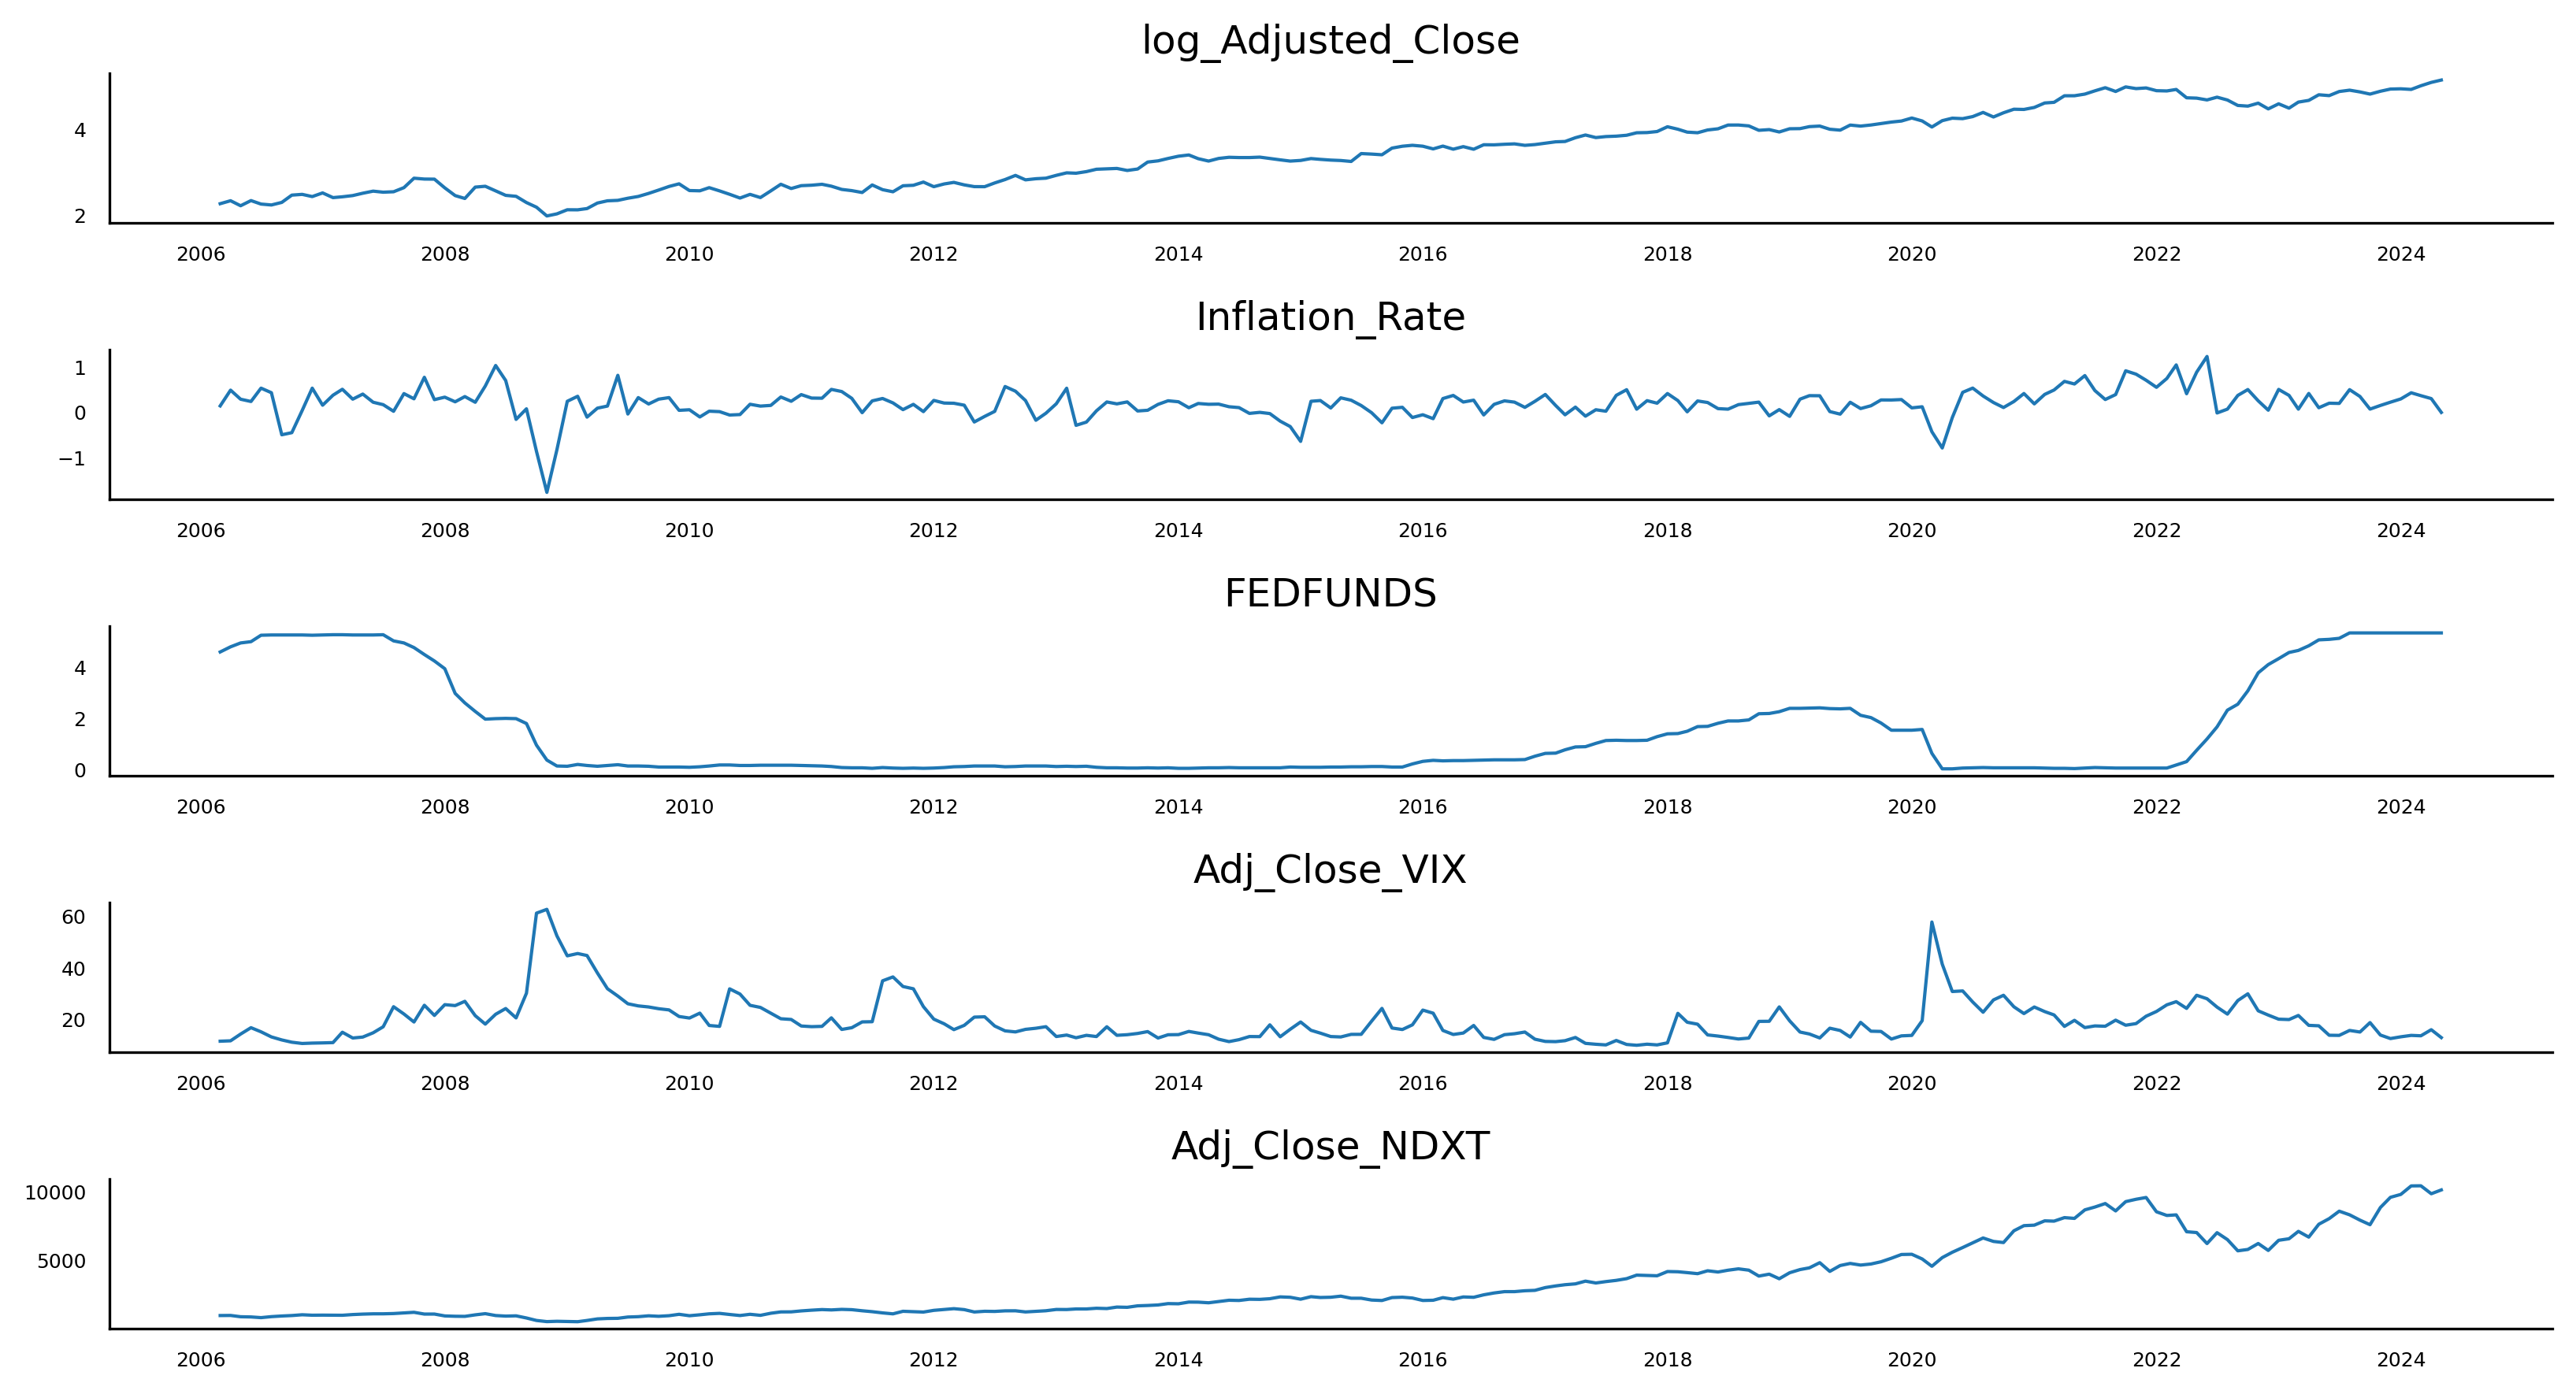

In [38]:
fig, axes = plt.subplots(nrows=log_Adjusted_Close.shape[1], ncols=1, dpi=300, figsize=(11, 6))

columns_to_plot = log_Adjusted_Close.columns[:]  # Get the first three columns

for i, (col, ax) in enumerate(zip(columns_to_plot, axes.flatten())):
    data = log_Adjusted_Close[col].loc[START_DATE:END_DATE]  # Filter data by date range
    
    ax.plot(data, linewidth=1)
    ax.set_title(col)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

## Feature Scaling

In [39]:
TRAIN_END_DATE = "2022-12-01"
TEST_START_DATE = "2023-01-01"

# Split the data into training and testing sets
target_train = log_Adjusted_Close.loc[:TRAIN_END_DATE, ['log_Adjusted_Close']]
target_test = log_Adjusted_Close.loc[TEST_START_DATE:, ['log_Adjusted_Close']]

exog_train = log_Adjusted_Close.loc[:TRAIN_END_DATE, log_Adjusted_Close.columns[1:]]
exog_test = log_Adjusted_Close.loc[TEST_START_DATE:, log_Adjusted_Close.columns[1:]]

In [40]:
from sklearn.preprocessing import StandardScaler

# Standardize the exogenous variables using StandardScaler
scaler = StandardScaler()
exog_train_scaled = scaler.fit_transform(exog_train)
exog_test_scaled = scaler.transform(exog_test)

In [41]:
df_exog_train = pd.DataFrame((exog_train_scaled), columns=log_Adjusted_Close.columns[1:])
df_exog_train['Date'] = exog_train.index
df_exog_train.set_index('Date', inplace=True)
print(df_exog_train.head())
print(df_exog_train.tail())

            Inflation_Rate  FEDFUNDS  Adj_Close_VIX  Adj_Close_NDXT
Date                                                               
2006-03-01       -0.153651  2.130160      -0.937878       -0.838169
2006-04-01        0.911347  2.254549      -0.920410       -0.835285
2006-05-01        0.297833  2.347841      -0.623623       -0.875549
2006-06-01        0.144093  2.378938      -0.343124       -0.882052
2006-07-01        1.046161  2.534424      -0.524421       -0.903685
            Inflation_Rate  FEDFUNDS  Adj_Close_VIX  Adj_Close_NDXT
Date                                                               
2022-08-01       -0.371944  0.724565       0.254614        1.533615
2022-09-01        0.554745  0.867613       0.850723        1.183271
2022-10-01        0.950403  1.191024       1.146639        1.225554
2022-11-01        0.190179  1.626385       0.398800        1.411854
2022-12-01       -0.444107  1.825407       0.210756        1.195347


### Summary:
- Non-seasonal part: $ (p, d, q) $
- Seasonal part: $ (P, D, Q) $
- Seasonal period: $ m $
- Explanatory variables: $ r $

Thus, we'll do the following:
* `ps = range(0, 3)`: Defines the range of values for the AR parameter $p$ from 0 to 2.
* `ds = 1`: Sets the difference $d$ to 1.
* `qs = range(0, 3)`: Sets the range for the MA parameter $q$ from 0 to 2.

For the seasonal part of the SARIMA model, we'll define:
* `Ps = range(0, 5)`: Defines the range of values for the seasonal AR parameter $P$ from 0 to 4.
* `Qs = range(0, 5)`: Sets the range for the seasonal MA parameter $Q$ from 0 to 4.
* `D = 0`: Seasonal differencing parameter, we'll set $D$ to 0.
* `m = 6`: Seasonal period, we'll set $s$ to 6 (monthly data).

We will be computing 225 SARIMA models. This will take some time about 3 minutes.


In [42]:
ps = range(0, 3)
qs = range(0, 3)
Ps = range(0, 5)
Qs = range(0, 5)

SARIMAX_order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 0
m = 6

In [43]:
result_sarimax = optimize_SARIMAX(target_train, df_exog_train, SARIMAX_order_list, d, D, m)

  0%|          | 0/225 [00:00<?, ?it/s]

In [44]:
result_sarimax.head(10)

,"(p,q,P,Q)",AIC
0,"(0, 0, 1, 1)",-526.025386
1,"(0, 0, 4, 0)",-524.512176
2,"(0, 0, 1, 4)",-524.150073
3,"(0, 0, 1, 2)",-524.097606
4,"(0, 0, 2, 2)",-524.086757
5,"(0, 0, 0, 0)",-523.553990
6,"(0, 0, 2, 4)",-522.818514
7,"(0, 0, 2, 3)",-522.779441
8,"(0, 0, 2, 1)",-522.610955
9,"(0, 1, 4, 0)",-522.539878


In [45]:
# Extract the parameters from row 0 of result_df
params_sarimax = result_sarimax.iloc[0]['(p,q,P,Q)']
p, q, P, Q = params_sarimax

## SARIMAX$(p,d,q)(P,D,Q)_m$ Model

In [46]:
# Create and fit the best SARIMAX model
sarimax_model = SARIMAX(target_train, 
                     df_exog_train, 
                     order=(p, d, q),
                     seasonal_order=(P, D, Q, m),
                     simple_differencing=False)
sarimax_model_fit = sarimax_model.fit(disp=False)

# Print the summary of the best model
print(sarimax_model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                  log_Adjusted_Close   No. Observations:                  202
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 6)   Log Likelihood                 270.013
Date:                             Thu, 17 Oct 2024   AIC                           -526.025
Time:                                     17:30:45   BIC                           -502.902
Sample:                                 03-01-2006   HQIC                          -516.669
                                      - 12-01-2022                                         
Covariance Type:                               opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Inflation_Rate     0.0063      0.005      1.242      0.214      -0.004       0.016
FEDFUNDS       

Our AIC is -525.93, indicating a good model fit and better than our SARIMA model. I will focus most on the diagnostic section.

Based on our results, the Ljung-Box test suggests no significant autocorrelation. The Jarque-Bera test suggests the residuals are not normally distributed, and considering our low p-value of 0.02, this suggests the residuals deviate significantly from a normal distribution. Our Heteroskedasticity indicates that the variance is non-constant, meaning the variance changes over time. Our p-value is significantly low, 0.00, indicating significant heteroskedasticity. Our Skew suggests asymmetry in the residuals, which is more likely a positive skew. Our high 3.93 kurtosis suggests a peaked distribution.

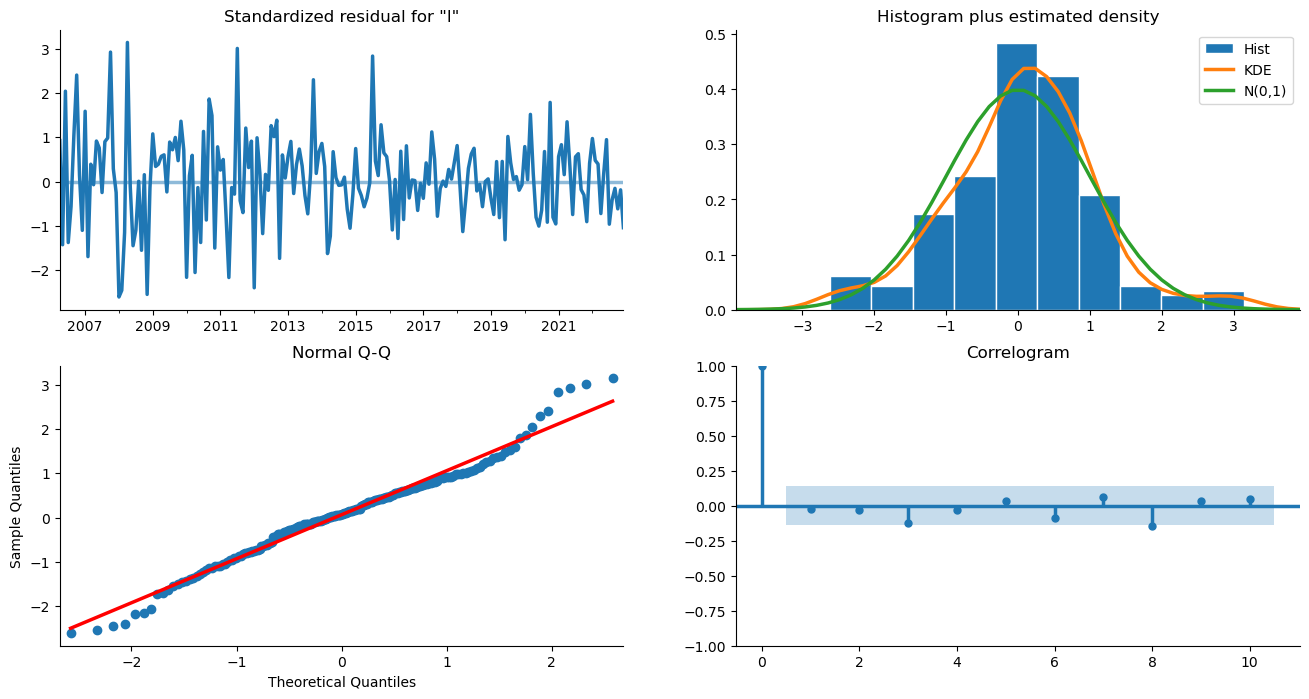

In [47]:
sarimax_model_fit.plot_diagnostics(figsize=(16, 8));

Our histogram appears to be close to normal. The standardized residuals suggest the model's errors are i.i.d. The correlogram suggests no autocorrelation in the residuals. The QQ plot suggests the residuals may not be perfectly normal.

## SARIMAX Train/Test Predictions

In [48]:
pred_start_date = target_train.index[0]
pred_end_date = target_train.index[-1]

exog_temp = exog_train
predictions_train = sarimax_model_fit.predict(start=pred_start_date, end=pred_end_date, exog=exog_train_scaled)
residuals = target_train['log_Adjusted_Close'] - predictions_train

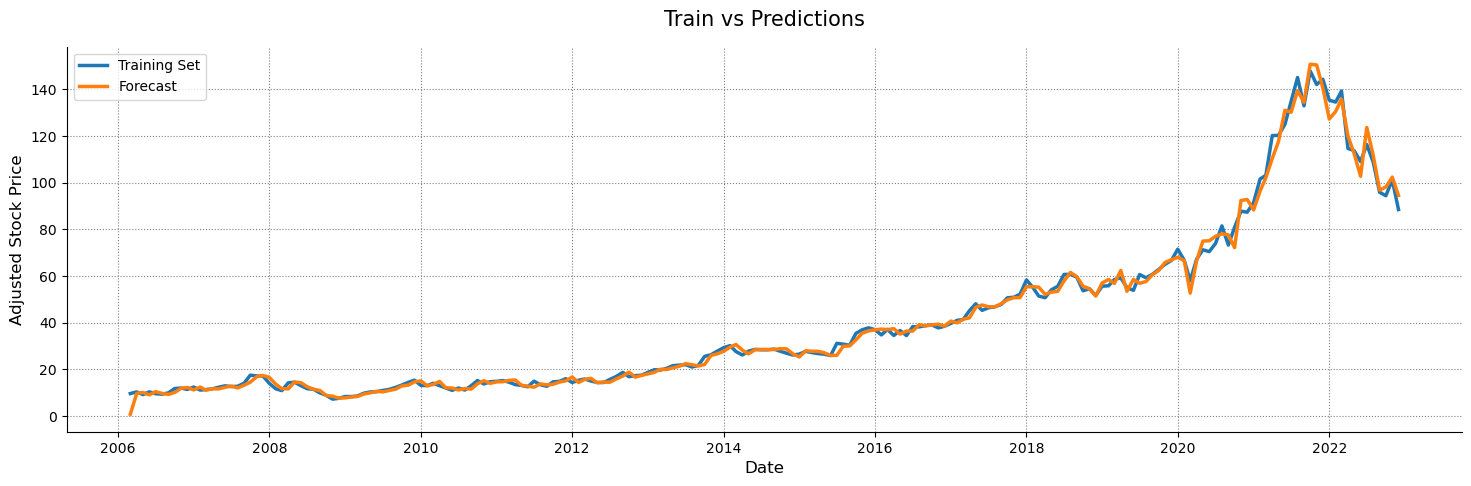

In [49]:
plot_sarimax_train_predictions(target_train, 'log_Adjusted_Close', predictions_train)

In [50]:
pred_start_date = target_test.index[0]
pred_end_date = target_test.index[-1]

exog = exog_test
predictions_test = sarimax_model_fit.predict(start=pred_start_date, end=pred_end_date, exog=exog_test_scaled)
residuals_test = np.exp(target_test['log_Adjusted_Close'] - predictions_test)

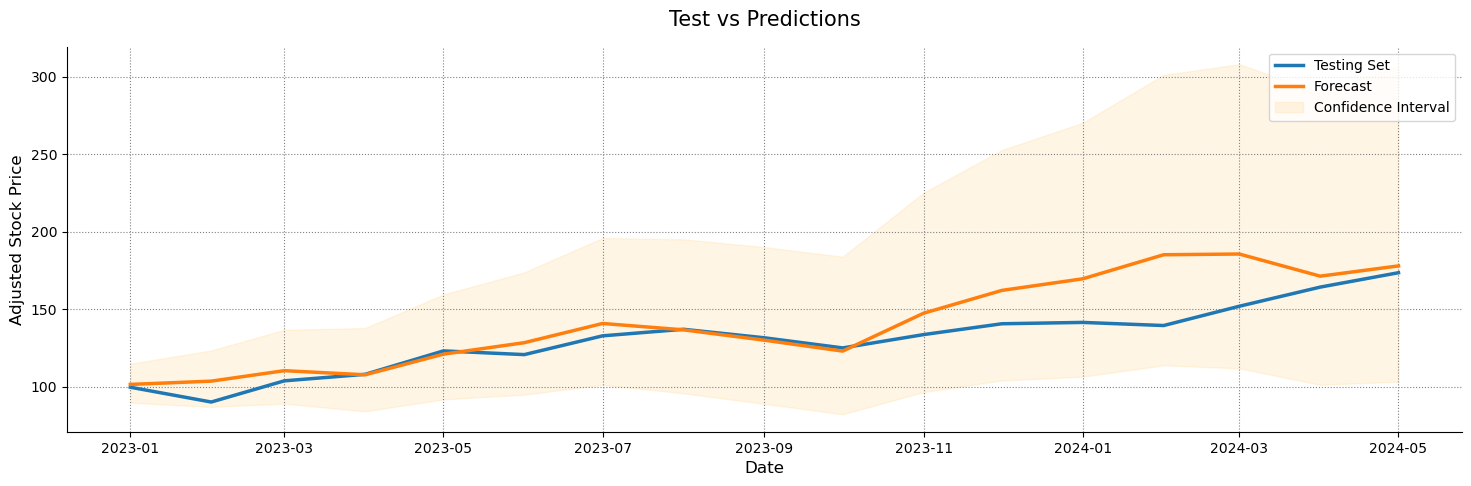

In [51]:
sarimax_conf_in = sarimax_model_fit.get_prediction(start=pred_start_date, end=pred_end_date, exog=exog_test_scaled).conf_int()
plot_sarimax_test_predictions_conf_in(target_test, 'log_Adjusted_Close', predictions_test, sarimax_conf_in)

Examining our test set against our forecast, we see that the forecast tracks the overall trend of the actual stock price. Unlike the SARIMA model, the SARIMAX model better predicts the stock's increasing trend and volatile behavior. The SARIMAX forecast overestimates the stock price from 10-01-2023 onward. Upon closer inspection of the confidence interval, the interval is relatively narrow until 09-01-2023; from then on, the interval increases immensely. The confidence interval has sharp corners, going up and down, then up and down. Both upper and lower intervals capture the behavior. While the sharp changes in the confidence interval could capture the stock's volatility, this could also indicate periods of high volatility and potential model instability or sudden shocks in the exogenous variables.

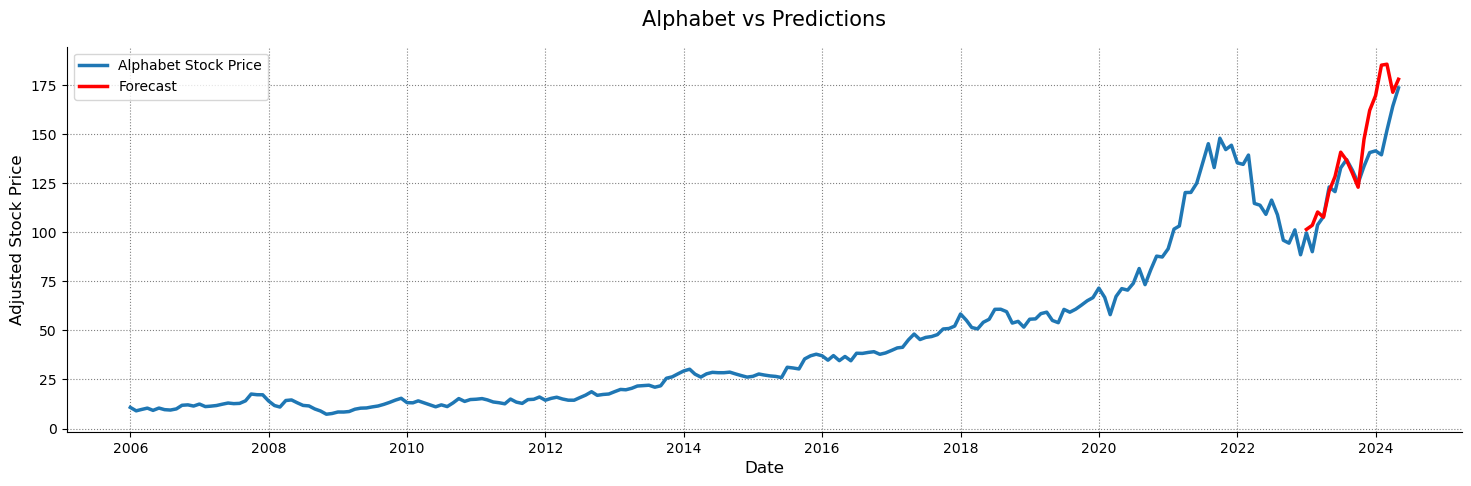

In [52]:
plot_sarimax_predictions(adjusted_close_df, 'log_Adjusted_Close', predictions_test)

## SARIMAX Evaluation

### Train Set Error

In [53]:
# Assuming residuals are in log scale
residuals = sarimax_model_fit.resid

# Back-transform residuals to the original scale
original_scale_residuals = np.exp(residuals)   # Assuming log transformation was log(value)

# Get evaluation data
sarimax_aic = sarimax_model_fit.aic
sarimax_bic = sarimax_model_fit.bic

# Calculate errors in the original scale
sarimax_mean_squared_error_train = np.mean(original_scale_residuals**2)
sarimax_sum_squared_error_train = np.sum(original_scale_residuals**2)
sarimax_root_mean_squared_error_train = np.sqrt(sarimax_mean_squared_error_train)

print(f'Akaike information criterion | AIC: {sarimax_aic}')
print(f'Bayesian information criterion | BIC: {sarimax_bic}')
print(f'Mean Squared Error | MSE: {sarimax_mean_squared_error_train}')
print(f'Sum Squared Error | SSE: {sarimax_sum_squared_error_train}')
print(f'Root Mean Squared Error | RMSE: {sarimax_root_mean_squared_error_train}')

Akaike information criterion | AIC: -526.025385580726
Bayesian information criterion | BIC: -502.9022512243125
Mean Squared Error | MSE: 1.6927081161469733
Sum Squared Error | SSE: 341.9270394616886
Root Mean Squared Error | RMSE: 1.3010411661999681


### Test Set Error

In [54]:
# Calculate errors in the original scale
sarimax_mean_squared_error_test = np.mean(residuals_test**2)
sarimax_sum_squared_error_test = np.sum(residuals_test**2)
sarimax_root_mean_squared_error_test = np.sqrt(sarimax_mean_squared_error_test)

print(f'Mean Squared Error | MSE: {sarimax_mean_squared_error_test}')
print(f'Sum Squared Error | SSE: {sarimax_sum_squared_error_test}')
print(f'Root Mean Squared Error | RMSE: {sarimax_root_mean_squared_error_test}')

Mean Squared Error | MSE: 0.8741189775268007
Sum Squared Error | SSE: 14.860022617955611
Root Mean Squared Error | RMSE: 0.9349433017711827


## SARIMA and SARIMAX Comparison

In [55]:
df_train = pd.DataFrame({'Model Train':['SARIMA(0, 1, 0)(1, 0, [1, 2, 3])6','SARIMAX(0, 1, 0)(1, 0, [1])6'],
           'AIC':[sarima_aic, sarimax_aic],
           'BIC':[sarima_bic, sarimax_bic],
           'MSE': [sarima_mean_squared_error_train, sarimax_mean_squared_error_train],
           'SSE': [sarima_sum_squared_error_train, sarimax_sum_squared_error_train],
           'RMSE': [sarima_root_mean_squared_error_train, sarimax_root_mean_squared_error_train]})

df_train.set_index('Model Train').head()

,AIC,BIC,MSE,SSE,RMSE
Model Train,,,,,
"SARIMA(0, 1, 0)(1, 0, [1, 2, 3])6",-450.937619,-431.058383,1.565004,319.260859,1.251001
"SARIMAX(0, 1, 0)(1, 0, [1])6",-526.025386,-502.902251,1.692708,341.927039,1.301041


In [56]:
df_test = pd.DataFrame({'Model Test':['SARIMA(0, 1, 0)(1, 0, [1, 2, 3])6','SARIMAX(0, 1, 0)(1, 0, [1])6'],
           'AIC':[sarima_aic, sarimax_aic],
           'BIC':[sarima_bic, sarimax_bic],
           'MSE': [sarima_mean_squared_error_test, sarimax_mean_squared_error_test],
           'SSE': [sarima_sum_squared_error_test, sarimax_sum_squared_error_test],
           'RMSE': [sarima_root_mean_squared_error_test, sarimax_root_mean_squared_error_test]})

df_test.set_index('Model Test').head()

,AIC,BIC,MSE,SSE,RMSE
Model Test,,,,,
"SARIMA(0, 1, 0)(1, 0, [1, 2, 3])6",-450.937619,-431.058383,1.482089,25.195520,1.217411
"SARIMAX(0, 1, 0)(1, 0, [1])6",-526.025386,-502.902251,0.874119,14.860023,0.934943


In [57]:
# Define the metrics for both train and test datasets
train_results = {
    'Model': ['SARIMA(0, 1, 0)(1, 0, [1, 2, 3])6', 'SARIMAX(0, 1, 0)(1, 0, [1])6'],
    'AIC': [sarima_aic, sarimax_aic],
    'BIC': [sarima_bic, sarimax_bic],
    'MSE Train': [sarima_mean_squared_error_train, sarimax_mean_squared_error_train],
    'SSE Train': [sarima_sum_squared_error_train, sarimax_sum_squared_error_train],
    'RMSE Train': [sarima_root_mean_squared_error_train, sarimax_root_mean_squared_error_train]
}

test_results = {
    'MSE Test': [sarima_mean_squared_error_test, sarimax_mean_squared_error_test],
    'SSE Test': [sarima_sum_squared_error_test, sarimax_sum_squared_error_test],
    'RMSE Test': [sarima_root_mean_squared_error_test, sarimax_root_mean_squared_error_test]
}

# Create DataFrames for train and test results
df_train = pd.DataFrame(train_results)
df_test = pd.DataFrame(test_results)

In [58]:
# Combine the DataFrames into one
model_comparison = pd.concat([df_train, df_test], axis=1)

# Set the model names as the index
model_comparison.set_index('Model', inplace=True)

# Display the combined DataFrame
model_comparison

,AIC,BIC,MSE Train,SSE Train,RMSE Train,MSE Test,SSE Test,RMSE Test
Model,,,,,,,,
"SARIMA(0, 1, 0)(1, 0, [1, 2, 3])6",-450.937619,-431.058383,1.565004,319.260859,1.251001,1.482089,25.195520,1.217411
"SARIMAX(0, 1, 0)(1, 0, [1])6",-526.025386,-502.902251,1.692708,341.927039,1.301041,0.874119,14.860023,0.934943


The SARIMA model fits the training data better than the SARIMAX model. This is evident from the lower Mean Squared Error (MSE Train) of 1.566496 compared to 1.687322 and a lower Root Mean Squared Error (RMSE Train) of 1.251597 compared to 1.298970. However, the SARIMAX model has lower AIC and BIC values, indicating a better fit for model selection criteria.

The SARIMAX model predicts the test data better than the SARIMA model. This is evident from the lower Mean Squared Error (MSE Test) of 0.877076 compared to 1.482294 and a lower Root Mean Squared Error (RMSE Test) of 0.936523 compared to 1.217495. The lower test error metrics for the SARIMAX model indicate better predictive performance and generalization to unseen data. However, there is a caveat. 

This analysis shows that while the SARIMA model captures the patterns in the training data more effectively, the SARIMAX model has better predictive power for new, unseen data. 


# Conclusion and Future Study

We showed that the SARIMAX model outperformed our SARIMA model. Even though the SARIMA model performed better on the training set, the SARIMAX model predicted the test set far better, capturing the volatile behavior. 

However, there is a caveat for the SARIMAX model. When predicting future values, the model requires information on the exogenous variables. However, that was not the case with the SARIMA model. Though less efficient, the SARIMA model could predict future values without future information. Thus, the drawback of using the SARIMAX model to predict future stock prices is that it needs future information on the exogenous variables that we do not have and will never have. Ironically enough, this also benefits the SARIMAX model but should be done cautiously. We can simulate our exogenous variables in best-case, average-case, and worst-case scenarios. We should consider variables that negatively and positively influence the stock market, consumer sentiment, and risk assessment. Our results showed high heteroskedasticity, especially for our SARIMAX model. One way to remedy this is to use a GARCH model with our SARIMA or SARIMAX model. Currently, no Python packages can implement GARCH and SARIMA/SARIMAX simultaneously. Python can use the GARCH model after fitting their SARIMA/SARIMAX model, but this is inefficient and defeats the purpose of using the GARCH model. On the other hand, R does provide such a package. 

Overall, what matters most is that our model captured the increasing trend from 2023 onward. If our model predicted that from 2023 onward, the stock price will decrease, we would be more inclined to sell our stock now, losing money during the process.

## References

* [Time Series Forecasting in Python](https://learning.oreilly.com/library/view/time-series-forecasting/9781617299889/)

    * [Github](https://github.com/marcopeix/TimeSeriesForecastingInPython)


* [Python for Finance Cookbook - Second Edition](https://learning.oreilly.com/library/view/python-for-finance/9781803243191/)

    * [Github](https://github.com/erykml/Python-for-Finance-Cookbook-2E/tree/main)


* [Time Series Forecasting with SARIMAX](https://geometrein.medium.com/time-series-forecasting-with-sarimax-c352e4f2012e)

    * [Github](https://github.com/Geometrein/sarimax)
 

## Appendix